# KNN

#### Boletín 1: evaluación y selección de modelos
#### Boletín 2: métodos basados en vecinos más próximos

Para la realización de las prácticas de esta segunda parte de la materia se utilizará scikit-learn, una
librería de aprendizaje estadístico en Python, a través de Jupyter Notebooks. La ejecución se realizará
en el CESGA siguiendo los pasos indicados en el archivo CESGA.pdf.


**[introduction.ipynb](http://localhost:8888/notebooks/4_seleccion_de_modelos_y_KNN/Introduction.ipynb)**

    En primer lugar, abre mediante ipython notebook el fichero introduction.ipynb, donde se describen algunas de las operaciones básicas necesarias para trabajar con scikit-learn: aprenderás a cargar los datos, realizar operaciones básicas con matrices, y representaciones gráficas.

**[knn.ipynb](http://localhost:8888/notebooks/4_seleccion_de_modelos_y_KNN/KNN.ipynb)**

    A continuación abre el fichero knn.ipynb. En este archivo se realiza la experimentación con un algoritmo sobre un conjunto de datos. Concretamente, se ha escogido el método de vecinos más cercanos, y un archivo con un problema muy simple (toyExample.data). Los pasos que se realizan son los siguientes:
    
    - Carga de datos y preprocesado básico.
    - División del conjunto de datos en entrenamiento y test.
    - Generación de los datos sobre los que se harán las representaciones gráficas.
    - Búsqueda de los mejores valores para los hiper-parámetros mediante validación cruzada.
    - Generación del modelo final, test y representación gráfica.
    - Guardar el modelo aprendido.

### Instrucciones para la experimentación en TODOS los boletines de prácticas

En los diferentes ejercicios que se realizarán durante el curso, existen una serie de operaciones con una componente aleatoria: la división en entrenamiento y test, el aprendizaje de un modelo o incluso, en
algunos casos, el test del modelo. Como norma general de experimentación es interesante asegurar la repetibilidad de los experimentos, eliminando la aleatoriedad, puesto que nos permite depurar errores,
comparar modelos, etc. Además, para la evaluación de los boletines también es imprescindible eliminar esa aleatoriedad.

Para ello vamos a fijar la semilla del generador de números aleatorios, de tal manera que su secuencia sea siempre la misma. La semilla se establece mediante el comando np.random.seed(SEED_VALUE), y
en este boletín utilizaremos un SEED_VALUE=1. Será necesario utilizar este comando inmediatamente antes de cualquier operación con un componente aleatorio. Esto incluye: train_test_split(), fit(),
predict(), etc. En aquellas funciones que lo admitan, sustituiremos el comando np.random.seed(SEED_VALUE) por el argumento random_state=SEED_VALUE.

In [1]:
!python --version

Python 3.11.5


In [2]:
!python3 --version

Python 3.11.5


## Importamos las librerías a utilizar

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
import matplotlib

import os
import itertools

In [4]:
%matplotlib inline
matplotlib.style.use('ggplot')
#np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en algunas gráficas
import warnings

# Filtrar y ocultar todos los warnings
warnings.filterwarnings('ignore')

## Definimos variables globales

In [5]:
DATASET_NAME = './data/Exercice.data'
DATASET_DELIMITER = ','
SEED_VALUE = 1  # NO CAMBIES ESTA SEMILLA, así todos tendremos los mismos resultados

# Ejercicio 1

Dado el siguiente conjunto de datos de clasificación con 6 observaciones, 3 variables de entrada y
una variable de salida:



## Leemos el fichero de datos

In [6]:

if os.path.exists(DATASET_NAME):
    dataset = pd.read_csv(DATASET_NAME, 
                          delimiter=DATASET_DELIMITER,
                          skiprows=0,
                          header=None,
                          names = ["X1", "X2", "X3", "Y"])
else:
    dataset = d.DataFrame(np.array(
    [[0, 3, 2, 1], 
    [3, 0, 3, 0], 
    [0, 3, -1, 0], 
    [3, 0, 0, 1], 
    [1, 2, 1, 1], 
    [2, 1, 0, 0]]), columns=['X1', 'X2', 'X3', 'Y'])
dataset

,X1,X2,X3,Y
0,0,3,2,1
1,3,0,3,0
2,0,3,-1,0
3,3,0,0,1
4,1,2,1,1
5,2,1,0,0


El fichero contiene 3 variables y 17 observaciones distintas. Las variables predictoras son `X0` y `X1`, y la variable dependiente sería `Y`. Estamos ante un problema de clasificación binario (dada la naturaleza booleana de `Y`, existen 2 clases).

## Visualizamos los datos

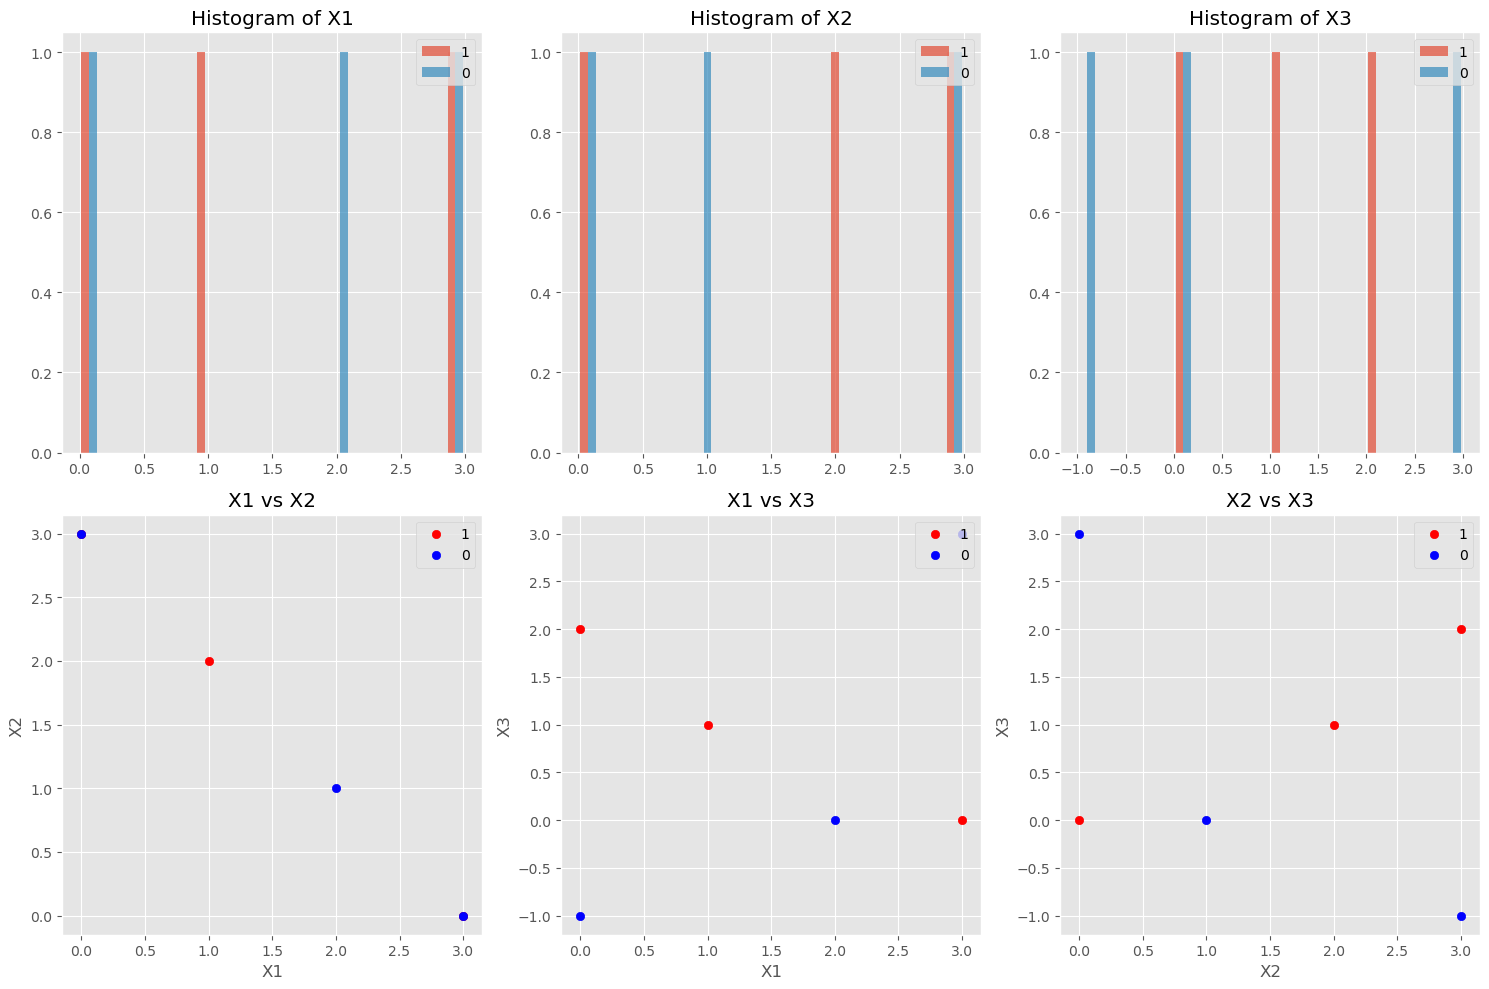

In [7]:

columns = dataset.columns[:-1]  # Exclude the 'Y' column

# Create a 2x3 subplot grid for both histogram and scatter plots
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Visualize histograms for the first three columns
for i, column in enumerate(columns[:3]):
    axs[0, i].hist([dataset[dataset['Y'] == 1][column], dataset[dataset['Y'] == 0][column]], label=['1', '0'], bins=20, alpha=0.7)
    axs[0, i].set_title("Histogram of {}".format(column))
    axs[0, i].legend(loc='upper right')

# Create combinations of variables for scatter plot comparison
combinations = list(itertools.combinations(columns, 2))

# Visualize scatter plots for the remaining combinations
for j, (var1, var2) in enumerate(combinations):
    k = j + 1  # Start from the second row
    scatter1 = axs[1, j].scatter(dataset[dataset['Y'] == 1][var1], dataset[dataset['Y'] == 1][var2], c='red', label='1')
    scatter0 = axs[1, j].scatter(dataset[dataset['Y'] == 0][var1], dataset[dataset['Y'] == 0][var2], c='blue', label='0')
    axs[1, j].set_title("{} vs {}".format(var1, var2))
    axs[1, j].set_xlabel(var1)
    axs[1, j].set_ylabel(var2)
    axs[1, j].legend(handles=[scatter1, scatter0], loc='upper right')

# Adjust layout
plt.tight_layout()
plt.show()

Suponiendo que se quiere hacer la predicción de la variable de salida para X1=0, X2=0, X3=0
mediante KNN.

In [8]:
# definimos nuestro punto para la prediccion
point=np.array([0,0,0])

**a)** Computar la distancia entre cada observación y el punto de test.

Usamos la distancia euclidania para este calculo


In [9]:
# Compute Euclidean distance for each observation
distances = np.sqrt(np.sum((dataset[['X1', 'X2', 'X3']] - point) ** 2, axis=1))
# Create a DataFrame to display the distances
distance_df = pd.DataFrame({
    'Observacion': dataset.apply(lambda row: '({}, {}, {})'.format(row["X1"], row["X2"], row["X3"]), axis=1),
    'Etiqueta_Observacion': dataset['Y'],
    'Punto': dataset.apply(lambda row: '({}, {}, {})'.format(point[0], point[1], point[2]), axis=1),
    'Distancia_Euclidiana': distances
})

# visualizarlo de manera vonita
display(distance_df)

,Observacion,Etiqueta_Observacion,Punto,Distancia_Euclidiana
0,"(0, 3, 2)",1,"(0, 0, 0)",3.605551
1,"(3, 0, 3)",0,"(0, 0, 0)",4.242641
2,"(0, 3, -1)",0,"(0, 0, 0)",3.162278
3,"(3, 0, 0)",1,"(0, 0, 0)",3.000000
4,"(1, 2, 1)",1,"(0, 0, 0)",2.449490
5,"(2, 1, 0)",0,"(0, 0, 0)",2.236068


**Nota:** este ejercicio debe hacerse sin utilizar ninguna función de scikit-learn. No es necesario
estandarizar las variables.

In [10]:
#Nota: este ejercicio debe hacerse sin utilizar ninguna función de scikit-learn. No es necesario estandarizar las variables
# Creamos nuestra propia función KNeighborsClassifier para no usar scikit-learn

def knn_classifier(X_train, y_train, X_test, K):
    """
    Clasificación KNN personalizada para un valor de K dado.
    
    Args:
    X_train (numpy.ndarray): Conjunto de entrenamiento (características).
    y_train (numpy.ndarray): Etiquetas del conjunto de entrenamiento.
    X_test (numpy.ndarray): Puntos de prueba (características) a clasificar.
    K (int): Número de vecinos cercanos a considerar.
    
    Returns:
    numpy.ndarray: Predicciones para los puntos de prueba.
    """
    predictions = []
    
    for test_point in X_test:
        # Calcula las distancias euclidianas entre el punto de prueba y todos los puntos de entrenamiento
        distances = np.sqrt(np.sum((X_train - test_point) ** 2, axis=1))
        
        # Encuentra los índices de los K vecinos más cercanos
        nearest_indices = np.argsort(distances)[:K]
        # Obtiene las etiquetas de los K vecinos más cercanos
        nearest_labels = y_train[nearest_indices]
        
        # Realiza una predicción basada en la mayoría de votos de los vecinos cercanos
        prediction = np.bincount(nearest_labels).argmax()
        predictions.append(prediction)
    
    return np.array(predictions)


In [11]:
#comparamos la salida de scikit-learn para comprobar que nuestra funcion esta bien
point_test=np.array([[0,0,0]]) 
X = dataset[['X1', 'X2', 'X3']]
y = dataset['Y']

# Valores de K para probar
k_values = [1,2,3,4,5]

# Almacenar resultados de precisión
accuracy_custom_knn = []
accuracy_sklearn_knn = []

# Evaluar diferentes valores de K
for K in k_values:
    # Usar nuestra función personalizada de KNN
    predictions_custom_knn = knn_classifier(X, y, point_test, K)
    accuracy_custom_knn.append(predictions_custom_knn)
    
    # Usar la implementación de scikit-learn de KNN
    knn = KNeighborsClassifier(n_neighbors=K)
    knn.fit(X, y)
    predictions_sklearn_knn = knn.predict(point_test)
    accuracy_sklearn_knn.append(predictions_sklearn_knn)

accuracy_custom_knn=np.array(accuracy_custom_knn)
accuracy_sklearn_knn=np.array(accuracy_sklearn_knn)
valores_distintos = np.setxor1d(accuracy_custom_knn, accuracy_sklearn_knn)
print("KNN custom",accuracy_custom_knn.T)
print("KNN sklearn",accuracy_custom_knn.T)
print("Son iguales: ",valores_distintos)

KNN custom [[0 0 1 0 1]]
KNN sklearn [[0 0 1 0 1]]
Son iguales:  []


Lo que demuestra es que tiene un comportamiento similar por lo que podemos usarla

**b)** ¿Cuál es la predicción para K=1? ¿Por qué?

Como podemos observar se etiqueta como 0. Puesto que en la tabla que antes generamos se pude observar el punto mas cercano al punto test es el (2,1,0) que está etiquetado como 0

In [12]:
prediction = knn_classifier(X,y,point_test,1)
# comparamos la salida de scikit-learn para comprobar que nuestra funcion esta bien
print('Prediction for K=1: {}'.format(prediction[0]))

Prediction for K=1: 0


**c)** ¿Cuál es la predicción para K=3? ¿Por qué?

Como podemos observar se etiqueta como 1. Puesto que en la tabla que antes generamos se pude observar los 3 punto mas cercano al punto test son el (2,1,0) que está etiquetado como 0 (1,2,1) que está etiquetado como 1 y el (3,0,0) que está etiquetado como 1, por lo que haber 2 vecinos etiquetados como 1 etiqueta el punto como 1

In [13]:
prediction = knn_classifier(X,y,point_test,3)

print('Prediction for K=3: {}'.format(prediction[0]))


Prediction for K=3: 1


# Ejercicio 2

Dado el problema de clasificación [Blood Transfusion Service Center](https://archive.ics.uci.edu/dataset/176/blood+transfusion+service+center):


**a)Analiza las características del conjunto de datos: número y tipo de variables de entrada y
salida, número de instancias, número de clases y distribución de las mismas, correlación
entre las variables, valores perdidos, etc.** 

## Leemos el fichero de datos

In [14]:
DATASET_BLOOD='./data/blood+transfusion+service+center/transfusion.data'
# Leer el archivo de datos y obtener la primera fila como nombres de columnas
data = pd.read_csv(DATASET_BLOOD)
NAME_BLOOD = data.columns.tolist()

NAME_BLOOD=["Reciente","Frecuencia","Cantidad_Sangre","Tiempo","Donacion_marzo"]
if os.path.exists(DATASET_BLOOD):
    dataset = pd.read_csv(DATASET_BLOOD, 
                          delimiter=DATASET_DELIMITER,
                          skiprows=1,
                          header=None,
                          names = NAME_BLOOD)
else:
    dataset = d.DataFrame(np.array(
    [[0, 3, 2, 1], 
    [3, 0, 3, 0], 
    [0, 3, -1, 0], 
    [3, 0, 0, 1], 
    [1, 2, 1, 1], 
    [2, 1, 0, 0]]), columns=['X1', 'X2', 'X3', 'Y'])
dataset

,Reciente,Frecuencia,Cantidad_Sangre,Tiempo,Donacion_marzo
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0
...,...,...,...,...,...
743,23,2,500,38,0
744,21,2,500,52,0
745,23,3,750,62,0
746,39,1,250,39,0


In [2]:
print('Tipo del dato de cada columna:')
print(df_blood_transfusion.dtypes)
# Comprobamos si hay nan
print("Cantidad de valores NaN en cada columna:")
df_blood_transfusion.isna().sum()

Tipo de dato de cada columna:


NameError: name 'df_blood_transfusion' is not defined



Cada columna de este DataFrame representa la siguiente información:

- Reciente (Recency (months)): el número de meses que han pasado desde la última donación.
- Frecuencia (Frequency (times)): el número total de donaciones de esta persona.
- Cantidad_Sangre (Monetary (c.c. blood)): cantidad total de sangre donada en centímetros cúbicos (c.c.).
- Tiempo (Time (months)): el número de meses desde la primera donación de esta persona.
- Donacion_marzo (whether he/she donated blood in March 2007): la variable a predecir, que nos indica si esta persona donó o no en Marzo de 2007 (1 significa que donó mientras que 0 indica que no donó).

siendo la cantidad de instancias dentro del dataset de 748


## Visualizamos los datos

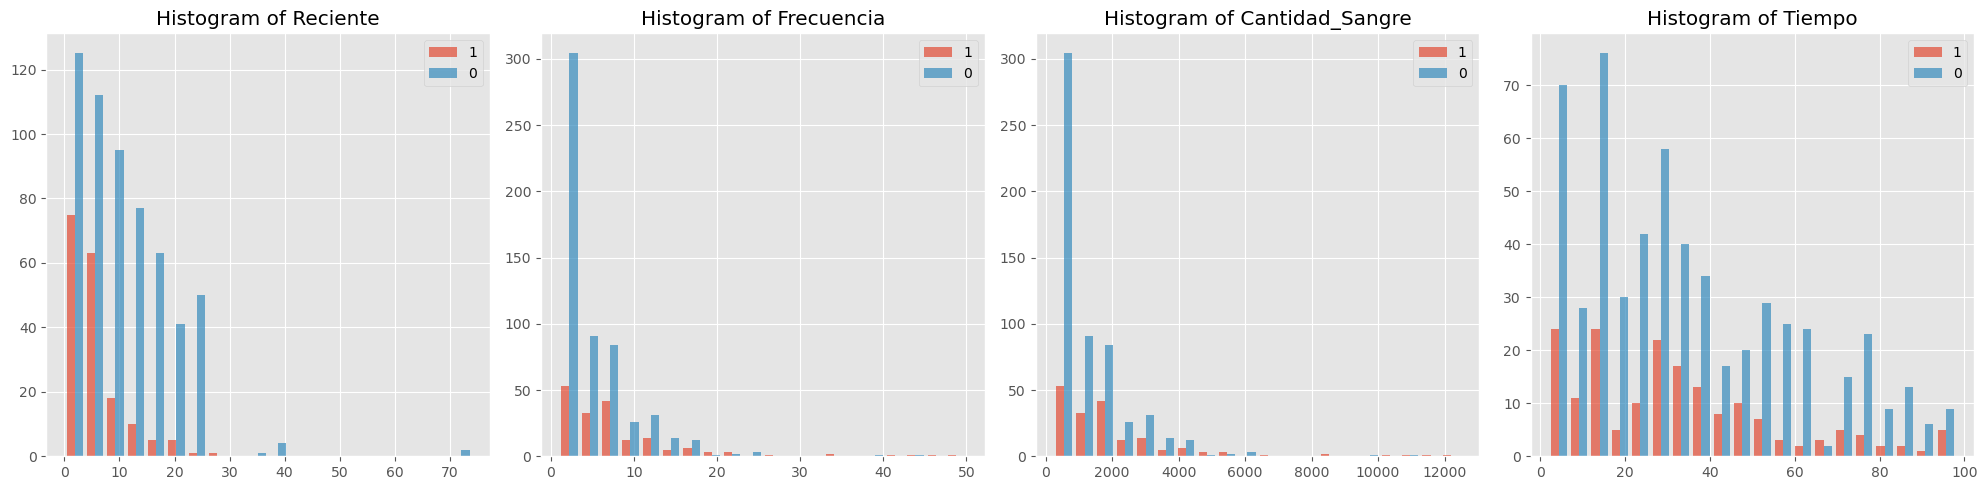

In [15]:
# Excluir la columna de la etiqueta
columns = dataset.columns[:-1]

# Crear una cuadrícula de subtramas 2x4 para histogramas y gráficos de dispersión
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Visualizar histogramas para todas las columnas
for i, column in enumerate(columns):
    axs[i].hist([dataset[dataset['Donacion_marzo'] == 1][column], 
                    dataset[dataset['Donacion_marzo'] == 0][column]], 
                   label=['1', '0'], bins=20, alpha=0.7)
    axs[i].set_title("Histogram of {}".format(column))
    axs[i].legend(loc='upper right')
# Ajustar el diseño
plt.tight_layout()
plt.show()



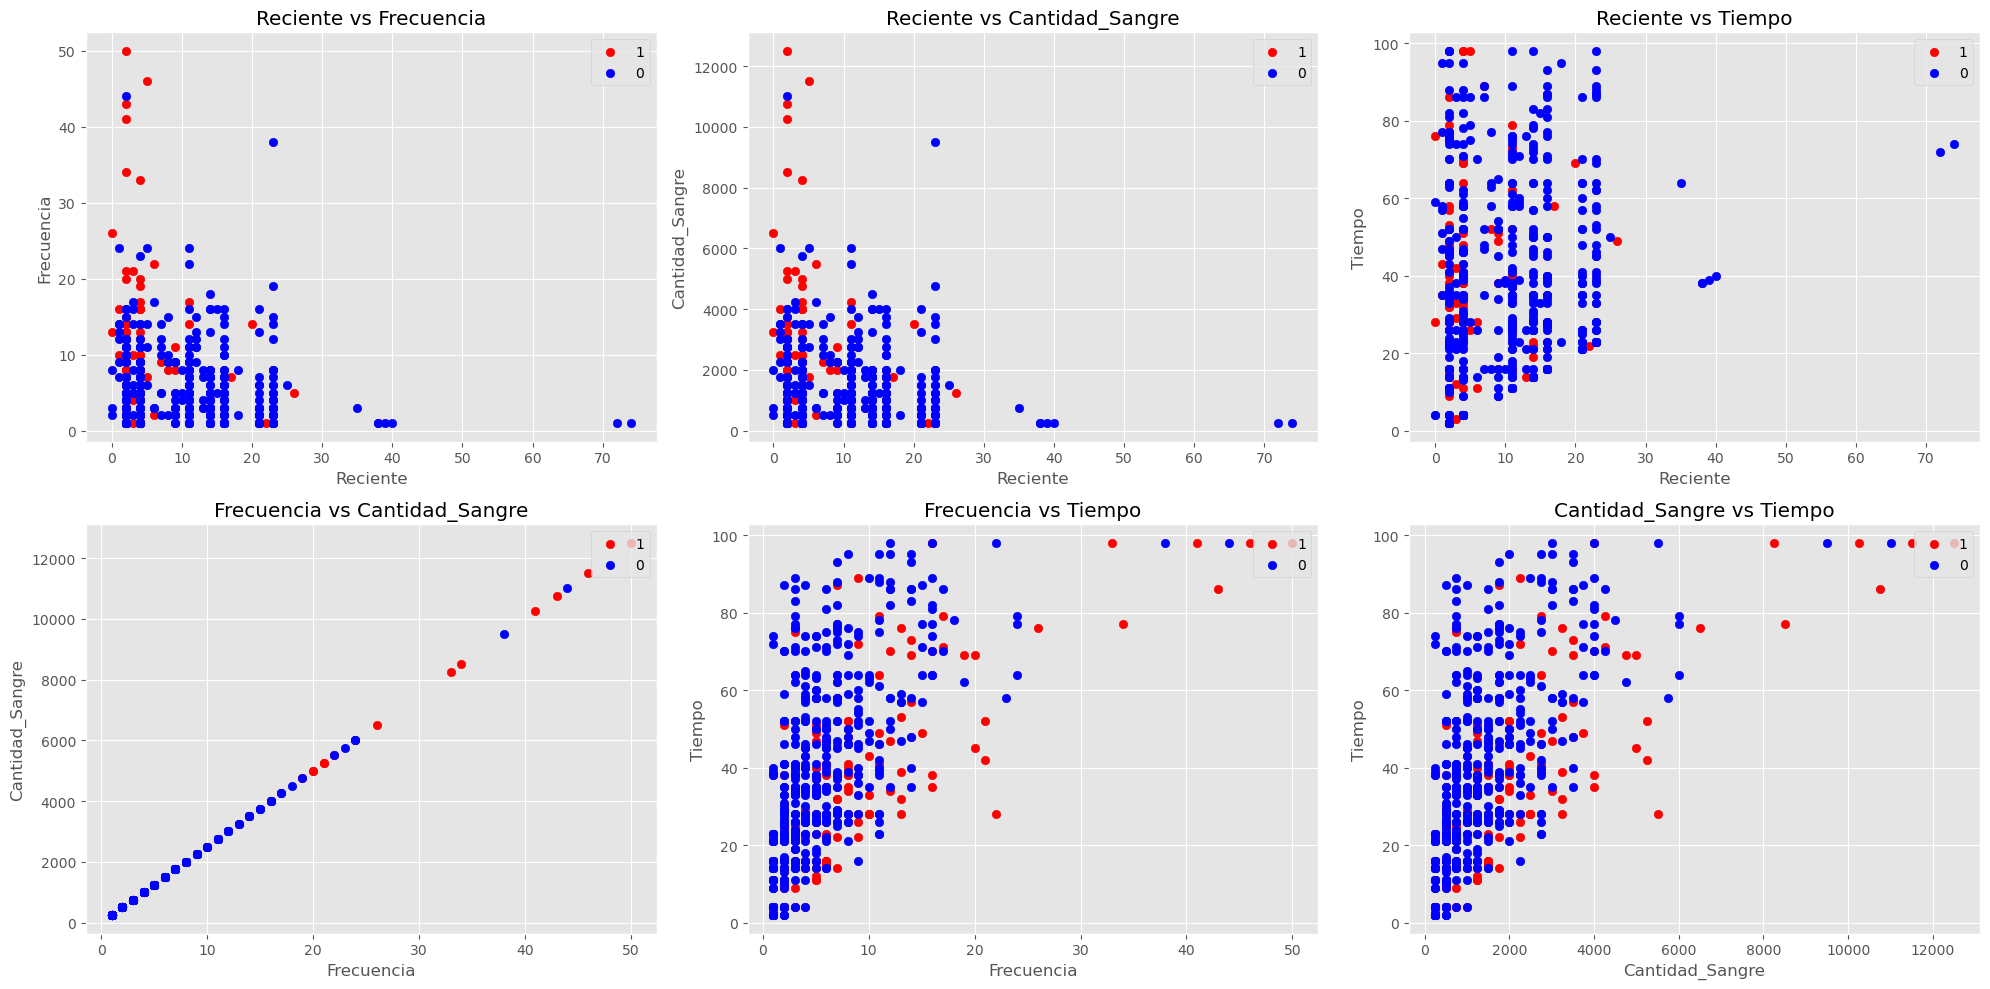

In [16]:
# Crear todas las combinaciones posibles de pares de variables
combinations = list(itertools.combinations(columns, 2))

# Calcular el número de filas necesario para acomodar todas las combinaciones
num_combinations = len(combinations)
num_rows = num_combinations // 3 + (num_combinations % 3 > 0)

# Crear una cuadrícula de subtramas con un número suficiente de filas para todas las combinaciones
fig, axs = plt.subplots(num_rows, 3, figsize=(20, num_rows * 5))  # Ajustar el tamaño de figura según sea necesario

# Visualizar gráficos de dispersión para todas las combinaciones
for j, (var1, var2) in enumerate(combinations):
    row = j // 3
    col = j % 3
    axs[row, col].scatter(dataset[dataset['Donacion_marzo'] == 1][var1], 
                          dataset[dataset['Donacion_marzo'] == 1][var2], 
                          c='red', label='1')
    axs[row, col].scatter(dataset[dataset['Donacion_marzo'] == 0][var1], 
                          dataset[dataset['Donacion_marzo'] == 0][var2], 
                          c='blue', label='0')
    axs[row, col].set_title("{} vs {}".format(var1, var2))
    axs[row, col].set_xlabel(var1)
    axs[row, col].set_ylabel(var2)
    axs[row, col].legend(loc='upper right')

# Ajustar el diseño para que no haya superposición
plt.tight_layout()

# Mostrar la figura
plt.show()

 **Nota**

- **Desequilibrio de Clases**: La primera fila de histogramas muestra un claro desequilibrio de clases entre aquellos que donaron sangre en marzo de 2007 (etiqueta '1') y aquellos que no lo hicieron (etiqueta '0'). Esto puede afectar el rendimiento del modelo de aprendizaje automático, ya que puede sesgarse hacia la clase más frecuente. Se recomienda aplicar técnicas de balanceo de clases como sobremuestreo, submuestreo o generación de datos sintéticos para manejar este desequilibrio.

- **Relación entre 'Frequency' y 'Monetary'**: La correlación directa entre 'Frequency' y 'Monetary' es evidente en el gráfico de dispersión de la esquina inferior derecha, lo que indica una relación lineal casi perfecta. Esto es coherente con la naturaleza de las variables, dado que 'Monetary' es probablemente un múltiplo de 'Frequency' (cada donación tiene un volumen fijo de sangre). Esto sugiere que una de las dos variables podría ser redundante para el modelado predictivo, y se podría considerar eliminar una para simplificar el modelo sin perder información significativa.

- **Posible correlación entre 'Time' y otras variables**: Los gráficos de dispersión 'Reciente vs Tiempo' y 'Frecuencia vs Tiempo' no muestran una relación lineal clara, pero sí sugieren algún tipo de relación. Por ejemplo, en 'Reciente vs Tiempo', hay una tendencia de que aquellos con valores más bajos de 'Reciente' tienen una distribución más amplia en 'Tiempo', lo que podría sugerir que los donantes nuevos tienden a tener un historial más corto de donaciones. Sin embargo, esta observación necesita ser investigada más a fondo, posiblemente con análisis estadísticos para establecer la fuerza y la significancia de la correlación.

- **Dispersión de los datos**: Hay una dispersión considerable en los datos, especialmente en los gráficos de dispersión 'Reciente vs Frecuencia' y 'Reciente vs Cantidad_Sangre', lo que podría indicar que la variable 'Reciente' tiene una relación menos directa con la frecuencia y la cantidad de donaciones en comparación con la relación entre 'Frecuencia' y 'Cantidad_Sangre'.


**PCA:** como observalos la relación entre 'Frequency' y 'Monetary' se podría hacer una reducción dimensional para mejorar el funconamiento de KNN 

**b)** Una de las clases que implementa el algoritmo KNN en scikit-learn sklearn.neighbors.KNeighborsClassifier. Revisa los parámetros y métodos que tiene.

El [sklearn.neighbors.KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) en scikit-learn es un clasificador que implementa la votación de los k-vecinos más cercanos. Aquí están sus parámetros y métodos basados en la documentación oficial de scikit-learn:

Parámetros:

- `n_neighbors` (int, por defecto=5): Número de vecinos a utilizar para consultas de kneighbors.
- `weights` ({'uniform', 'distance'} o callable, por defecto='uniform'): Función de peso utilizada en la predicción.
- `algorithm` ({'auto', 'ball_tree', 'kd_tree', 'brute'}, por defecto='auto'): Algoritmo utilizado para calcular los vecinos más cercanos.
- `leaf_size` (int, por defecto=30): Tamaño de hoja pasado a BallTree o KDTree.
- `p` (float, por defecto=2): Parámetro de potencia para la métrica de Minkowski.
- `metric` (str o callable, por defecto='minkowski'): La métrica de distancia a utilizar para el árbol.
- `metric_params` (dict, por defecto=None): Argumentos adicionales de palabras clave para la función métrica.
- `n_jobs` (int, por defecto=None): El número de trabajos paralelos a ejecutar para la búsqueda de vecinos.

Métodos:

- `fit`(X, y): Ajustar el clasificador a partir del conjunto de datos de entrenamiento.
- `get_metadata_routing`(): Obtener el enrutamiento de metadatos del objeto.
- `get_params`([deep]): Obtener los parámetros para este estimador.
- `kneighbors`([X, n_neighbors, return_distance]): Encontrar los K-vecinos de un punto.
- `kneighbors_graph`([X, n_neighbors, mode]): Calcular el grafo (ponderado) de k-Vecinos para los puntos en X.
- `predict`(X): Predecir las etiquetas de clase para los datos proporcionados.
- `predict_proba`(X): Devolver las estimaciones de probabilidad para los datos de prueba X.
- `score`(X, y[, sample_weight]): Devolver la precisión media en los datos de prueba y etiquetas proporcionados.
- `set_params`(**params): Establecer los parámetros de este estimador.
- `set_score_request`(*[, sample_weight]): Solicitar metadatos pasados al método `score`.


n_neighbors: 3, weights: uniform, Accuracy: 0.79
n_neighbors: 3, weights: distance, Accuracy: 0.79
n_neighbors: 5, weights: uniform, Accuracy: 0.80
n_neighbors: 5, weights: distance, Accuracy: 0.80
n_neighbors: 10, weights: uniform, Accuracy: 0.80
n_neighbors: 10, weights: distance, Accuracy: 0.80


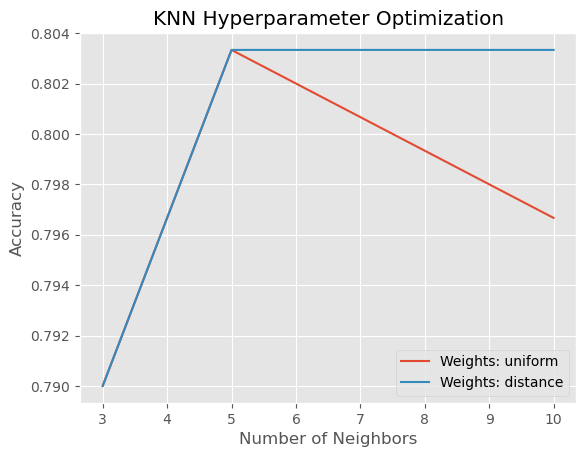

In [17]:
from sklearn.datasets import make_classification
# Create a synthetic dataset
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=2, random_state=42)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define hyperparameters to test
n_neighbors_options = [3, 5, 10]
weights_options = ['uniform', 'distance']

# Store the results
results = []

# Loop over hyperparameters
for n_neighbors in n_neighbors_options:
    for weights in weights_options:
        # Create and fit the model
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
        knn.fit(X_train, y_train)
        
        # Make predictions
        y_pred = knn.predict(X_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        
        # Store results
        results.append((n_neighbors, weights, accuracy))

# Print results
for n_neighbors, weights, accuracy in results:
    print("n_neighbors: {}, weights: {}, Accuracy: {:.2f}".format(n_neighbors, weights, accuracy))
    

# Plot results
fig, ax = plt.subplots()
for weights in weights_options:
    ax.plot(n_neighbors_options, [acc for n, w, acc in results if w == weights], label='Weights: {}'.format(weights))

ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy')
ax.set_title('KNN Hyperparameter Optimization')
ax.legend()
plt.show()

**c)** División de los datos en entrenamiento (80%) y test (20%):

<span style="color:red">**MUY IMPORTANTE:**</span> Vamos a establecer una semilla con un valor predefinido inmediatamente antes de ejecutar cualquier operación con un componente aleatorio. Así aseguramos que nuestros resultados sean repetibles.

Esto es, vamos a poner `np.random.seed(SEED_VALUE)` antes de:
 - `fit()`
 - `predict()`
 
En aquellas funciones que lo admitan, sustituiremos el comando np.random.seed(SEED_VALUE) por el argumento `random_state=SEED_VALUE`. Por ejemplo, para la división de datos entre entrenamiento y test con `train_test_split`.

In [18]:
# tenemos mas ejemplos de una categoria que en otra si queremos hacer una experimentación para el conjunto de test 
# con stratify mantenga el mismo poncentaje de cadad clase  en el test y en el train en este 
# caso es para que train si hay 2 categorias mantenga la proporcion de estas en train y test decir que si en el total 
# tenemos 60% 1 y 40% 2 se intenta man tener el porcentaje de dataos 
dataset_train, dataset_test = train_test_split(dataset,
                            test_size=0.2, random_state=SEED_VALUE,
                                               stratify=dataset["Donacion_marzo"])
dataset_test

,Reciente,Frecuencia,Cantidad_Sangre,Tiempo,Donacion_marzo
309,16,3,750,19,0
711,23,6,1500,45,0
343,11,1,250,11,0
462,21,1,250,21,1
646,14,2,500,14,0
...,...,...,...,...,...
315,4,2,500,29,0
473,14,3,750,83,0
661,16,2,500,16,0
362,4,3,750,71,0


## Gestión de valores faltantes

En este caso, nuestro dataset no tiene valores faltantes.
Sin embargo, la sustitución de las variables predictoras por la media se llevaría a cabo de la siguiente manera.

In [19]:
imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
imp = imp.fit(dataset_train)  # La media la calculamos SÓLO a partir del conjunto de train

# Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
dataset_train_prep = imp.transform(dataset_train)
dataset_test_prep = imp.transform(dataset_test)

dataset_test_prep

array([[1.600e+01, 3.000e+00, 7.500e+02, 1.900e+01, 0.000e+00],
       [2.300e+01, 6.000e+00, 1.500e+03, 4.500e+01, 0.000e+00],
       [1.100e+01, 1.000e+00, 2.500e+02, 1.100e+01, 0.000e+00],
       [2.100e+01, 1.000e+00, 2.500e+02, 2.100e+01, 1.000e+00],
       [1.400e+01, 2.000e+00, 5.000e+02, 1.400e+01, 0.000e+00],
       [2.100e+01, 3.000e+00, 7.500e+02, 4.000e+01, 0.000e+00],
       [2.300e+01, 1.000e+00, 2.500e+02, 2.300e+01, 0.000e+00],
       [4.000e+00, 6.000e+00, 1.500e+03, 3.500e+01, 1.000e+00],
       [2.000e+00, 2.000e+00, 5.000e+02, 4.000e+00, 1.000e+00],
       [9.000e+00, 2.000e+00, 5.000e+02, 1.100e+01, 0.000e+00],
       [4.000e+00, 8.000e+00, 2.000e+03, 2.100e+01, 0.000e+00],
       [1.400e+01, 2.000e+00, 5.000e+02, 1.400e+01, 1.000e+00],
       [9.000e+00, 9.000e+00, 2.250e+03, 1.600e+01, 0.000e+00],
       [4.000e+00, 7.000e+00, 1.750e+03, 3.200e+01, 1.000e+00],
       [4.000e+00, 9.000e+00, 2.250e+03, 2.600e+01, 1.000e+00],
       [1.100e+01, 4.000e+00, 1.000e+03,

`SimpleImputer` ha convertido nuestros valores a un array NumPy, por lo que sería bueno que los volviéramos a convertir en formato dataframe.

In [20]:
dataset_train = pd.DataFrame(dataset_train_prep,
                             columns=dataset_train.columns,
                             index=dataset_train.index)
dataset_test = pd.DataFrame(dataset_test_prep,
                            columns=dataset_test.columns,
                            index=dataset_test.index)

dataset_test

,Reciente,Frecuencia,Cantidad_Sangre,Tiempo,Donacion_marzo
309,16.0,3.0,750.0,19.0,0.0
711,23.0,6.0,1500.0,45.0,0.0
343,11.0,1.0,250.0,11.0,0.0
462,21.0,1.0,250.0,21.0,1.0
646,14.0,2.0,500.0,14.0,0.0
...,...,...,...,...,...
315,4.0,2.0,500.0,29.0,0.0
473,14.0,3.0,750.0,83.0,0.0
661,16.0,2.0,500.0,16.0,0.0
362,4.0,3.0,750.0,71.0,0.0


## Separación de variables predictoras y dependientes

In [21]:
dataset_train_X = dataset_train.loc[:, NAME_BLOOD[:-1]].astype(float)
dataset_train_Y = dataset_train.loc[:, NAME_BLOOD[-1]]
dataset_train_X


,Reciente,Frecuencia,Cantidad_Sangre,Tiempo
619,4.0,1.0,250.0,4.0
357,14.0,3.0,750.0,26.0
405,14.0,3.0,750.0,41.0
700,16.0,3.0,750.0,35.0
479,23.0,1.0,250.0,23.0
...,...,...,...,...
63,4.0,5.0,1250.0,16.0
569,2.0,6.0,1500.0,45.0
83,2.0,4.0,1000.0,16.0
37,4.0,6.0,1500.0,16.0


In [22]:
dataset_test_X = dataset_test.loc[:, NAME_BLOOD[:-1]].astype(float)
dataset_test_Y = dataset_test.loc[:, NAME_BLOOD[-1]]

dataset_test_X

,Reciente,Frecuencia,Cantidad_Sangre,Tiempo
309,16.0,3.0,750.0,19.0
711,23.0,6.0,1500.0,45.0
343,11.0,1.0,250.0,11.0
462,21.0,1.0,250.0,21.0
646,14.0,2.0,500.0,14.0
...,...,...,...,...
315,4.0,2.0,500.0,29.0
473,14.0,3.0,750.0,83.0
661,16.0,2.0,500.0,16.0
362,4.0,3.0,750.0,71.0


## Estandarización de los datos

Esto hay que hacerlo **DESPUÉS** de dividir en conjuntos de entrenamiento y test.

Además, como es un problema de clasificación, **NO** estandarizaremos la variable dependiente.

In [23]:
scaler = StandardScaler()

scaler.fit(dataset_train_X)

dataset_train_X_scaled = scaler.transform(dataset_train_X)
dataset_test_X_scaled = scaler.transform(dataset_test_X)

dataset_test_X_scaled

array([[ 8.22450908e-01, -4.47487686e-01, -4.47487686e-01,
        -6.42119939e-01],
       [ 1.70930807e+00,  6.15756676e-02,  6.15756676e-02,
         4.09236507e-01],
       [ 1.88981507e-01, -7.86863255e-01, -7.86863255e-01,
        -9.65614230e-01],
       [ 1.45592031e+00, -7.86863255e-01, -7.86863255e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
        -8.44303871e-01],
       [ 1.45592031e+00, -4.47487686e-01, -4.47487686e-01,
         2.07052575e-01],
       [ 1.70930807e+00, -7.86863255e-01, -7.86863255e-01,
        -4.80372793e-01],
       [-6.97875655e-01,  6.15756676e-02,  6.15756676e-02,
         4.86864317e-03],
       [-9.51263415e-01, -6.17175470e-01, -6.17175470e-01,
        -1.24867173e+00],
       [-6.44062535e-02, -6.17175470e-01, -6.17175470e-01,
        -9.65614230e-01],
       [-6.97875655e-01,  4.00951237e-01,  4.00951237e-01,
        -5.61246366e-01],
       [ 5.69063148e-01, -6.17175470e-01, -6.17175470e-01,
      

Estos son los valores con los que se ha estandarizado.

In [24]:
print("mean {}: {}  |  std {}: {}".format(NAME_BLOOD[:-1],scaler.mean_, NAME_BLOOD[:-1],scaler.scale_))

mean ['Reciente', 'Frecuencia', 'Cantidad_Sangre', 'Tiempo']: [   9.5083612     5.63712375 1409.28093645   34.87959866]  |  std ['Reciente', 'Frecuencia', 'Cantidad_Sangre', 'Tiempo']: [   7.89304107    5.89317612 1473.29403119   24.72995729]


## Empezamos con la experimentación de KNN

Hemos visualizado y preprocesado los datos. Vamos a empezar a trabajar con nuestro predictor.

## Definimos un rango de hiperparámetros para realizar las pruebas

In [25]:

hyperparameters = {
    'n_neighbors': range(1, 598, 1),
    'weights': ['uniform', 'distance'],  # 'callable' no es un valor literal válido, se debe reemplazar con una función concreta si se desea usar.
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': range(1, 50),  # Por ejemplo, valores entre 1 y 50. El valor óptimo puede variar dependiendo del tamaño del conjunto de datos.
    'p': [1, 2],  # 1 corresponde a la distancia de Manhattan y 2 a la distancia euclidiana.
    'metric': ['minkowski', 'euclidean', 'manhattan'],  # Puedes agregar más métricas compatibles con tu conjunto de datos.
    # 'metric_params': None,  # Este es un diccionario de parámetros adicionales para la función métrica y su estructura dependerá de la métrica específica que estés utilizando.
    'n_jobs': [-1]  # Utilizar -1 para usar todos los procesadores disponibles y acelerar la búsqueda.
}
# hay que llegar en los extremos las graficas de aqui pued ser minimo local y hay que exporara un poco mas

# Expected n_neighbors <= n_samples,  n_samples = 477
# Si solo necesitas el número de muestras
n_samples = dataset_train_X_scaled.shape[0]

# ('Numero de muestras:', 598) auque pone este valor al usar  GridSearchCV me indica que son 477
print("Numero de muestras:", n_samples)

hyperparameters = {
    'n_neighbors': range(1, 477, 1),
    'n_jobs': [-1]  # Utilizar -1 para usar todos los procesadores disponibles y acelerar la búsqueda.
}
# hay


Numero de muestras: 598


## Comenzamos las pruebas con 5-CV

In [26]:
k_neigh = KNeighborsClassifier()
modelCV = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy', # parametro  top mejores en regresion mean scare error(skle pueda dar - std)
                       return_train_score=True)  # El warning es normal, pues el ejemplo es demasiado pequeño

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
modelCV.fit(dataset_train_X_scaled, dataset_train_Y)  # En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': range(1, 477)},
             return_train_score=True, scoring='accuracy')

Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor
del hiper-parámetro.
**¿Cuál es el menor error de validación cruzada, su desviación estándar
y el valor del hiper-parámetro para el que se consigue? ¿Cuál es el valor del hiper-
parámetro si se aplicase la regla de una desviación estándar? En caso de que haya varios
modelos con error mínimo, debe seleccionarse siempre el más simple.**

## Resultados obtenidos en 5-CV

Puede verse el ranking de los mejores

In [27]:
cv_results = pd.DataFrame(modelCV.cv_results_)
cv_results.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,1,0.715700,0.042714,476
1,2,0.774216,0.018687,60
2,3,0.750784,0.024933,475
3,4,0.767535,0.022283,65
4,5,0.774258,0.018939,56
...,...,...,...,...
471,472,0.762549,0.003516,95
472,473,0.762549,0.003516,95
473,474,0.762549,0.003516,95
474,475,0.762549,0.003516,95


Los mejores hiperparámetros en validación serían los siguientes (aunque no siempre conviene quedarse con los mejores):

In [28]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
35,36,0.79937,0.021447,1


## Gráfica de entrenamiento

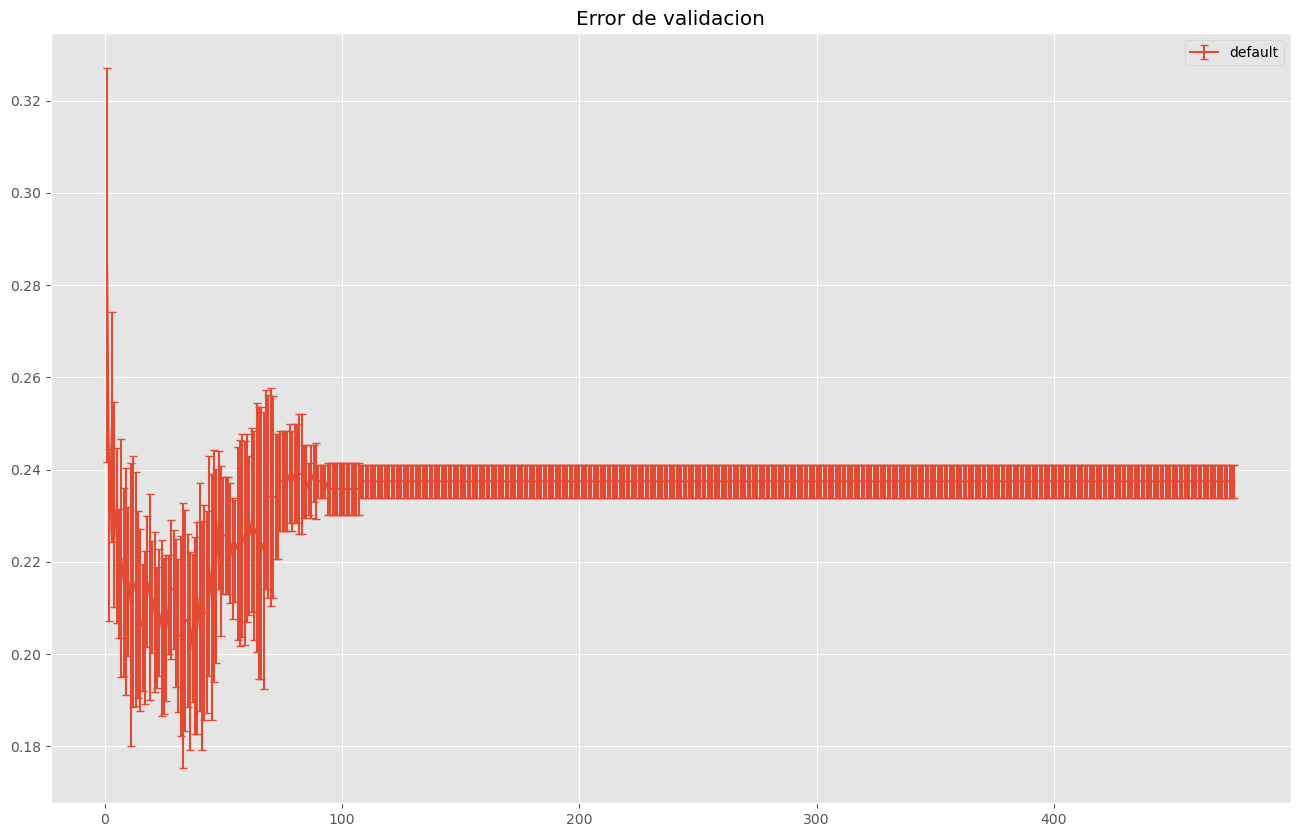

In [29]:
# separamos los pesos basados en cada 
cv_results_uniform = cv_results

plt.figure(figsize=(16, 10))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion")
plt.errorbar(cv_results_uniform['param_n_neighbors'],1 - cv_results_uniform['mean_test_score'],
             cv_results_uniform['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

Se observa que apartir de ciento numero el error es constante y con la misma variación por lo que haremos un acercamiento a a la parte del grafico que  tiene variación para poder observar mejor esta sección. 

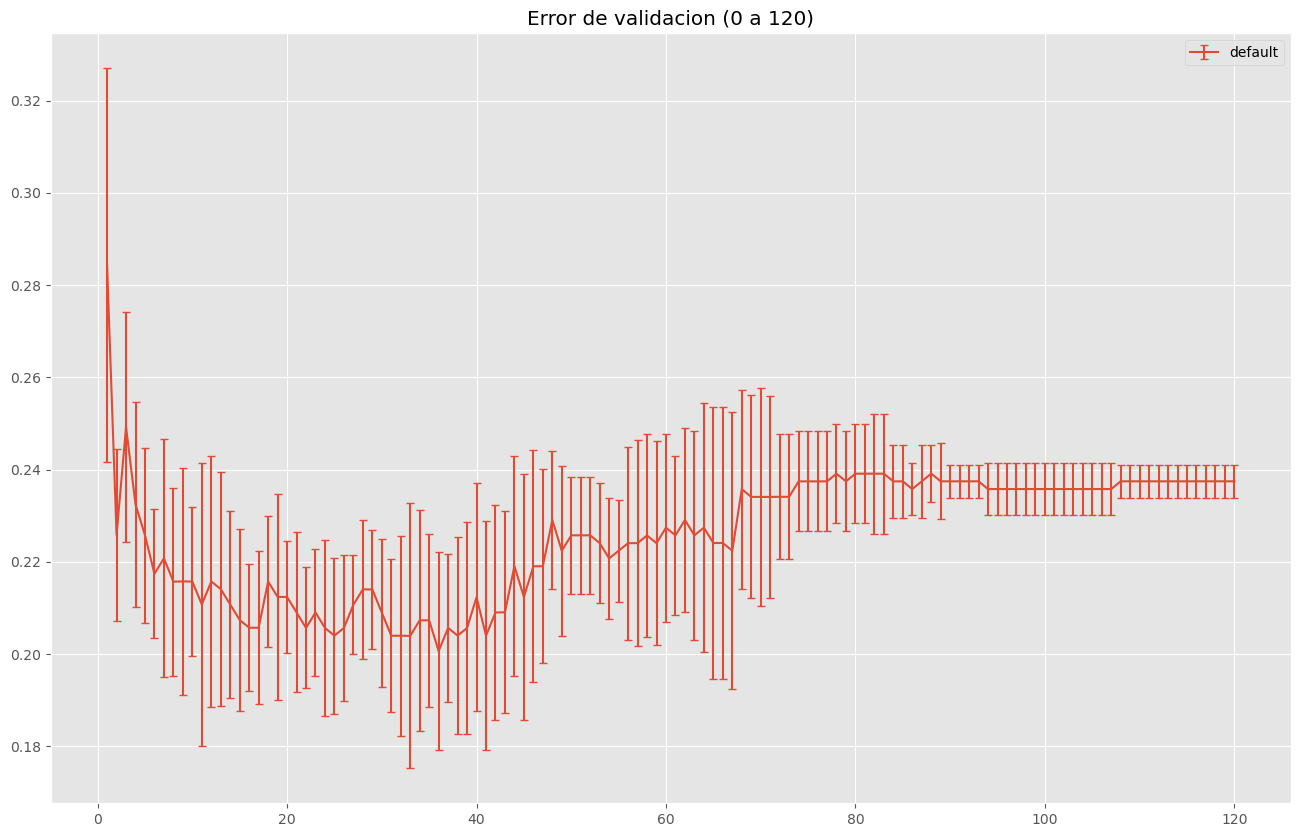

In [30]:
# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_uniform[cv_results_uniform['param_n_neighbors'] <= 120]
plt.errorbar(subset['param_n_neighbors'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [31]:
# Resultados obtenidos en 5-CV
cv_results = pd.DataFrame(modelCV.cv_results_)
# Guardar los resultados completos en un archivo CSV
cv_results.to_csv('cv_results.csv', index=False)

# Filtrar y guardar los mejores resultados
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
cv_results_best.to_csv('cv_results_best.csv', index=False)

# Separar los resultados por tipo de peso y guardarlos
cv_results_uniform = cv_results
cv_results_uniform.to_csv('cv_results_uniform.csv', index=False)


In [32]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1].sort_values(by='param_n_neighbors')
cv_results_best.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
35,36,0.79937,0.021447,1


In [33]:
# Aplicar la regla de una desviación estándar
best_model = cv_results[cv_results['rank_test_score'] == 1].sort_values(by='param_n_neighbors').iloc[0]
mejor_score = best_model['mean_test_score']
mejor_std = best_model['std_test_score']


threshold =  mejor_score -  mejor_std

cv_results_aux = cv_results[
     cv_results['mean_test_score']>= threshold
].sort_values(by='param_n_neighbors', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux = cv_results_aux.sort_values(by='param_n_neighbors')
cv_results_aux



,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
5,6,0.782605,0.013973,38
6,7,0.779244,0.025804,43
7,8,0.784314,0.020409,33
8,9,0.784258,0.024577,37
9,10,0.784286,0.016105,35
10,11,0.789258,0.030783,25
11,12,0.784272,0.027148,36
12,13,0.785924,0.025314,32
13,14,0.789272,0.020307,24
14,15,0.792605,0.019735,17


In [34]:
cv_results_aux.iloc[-1]

param_n_neighbors          54
mean_test_score      0.779286
std_test_score       0.013208
rank_test_score            42
Name: 53, dtype: object

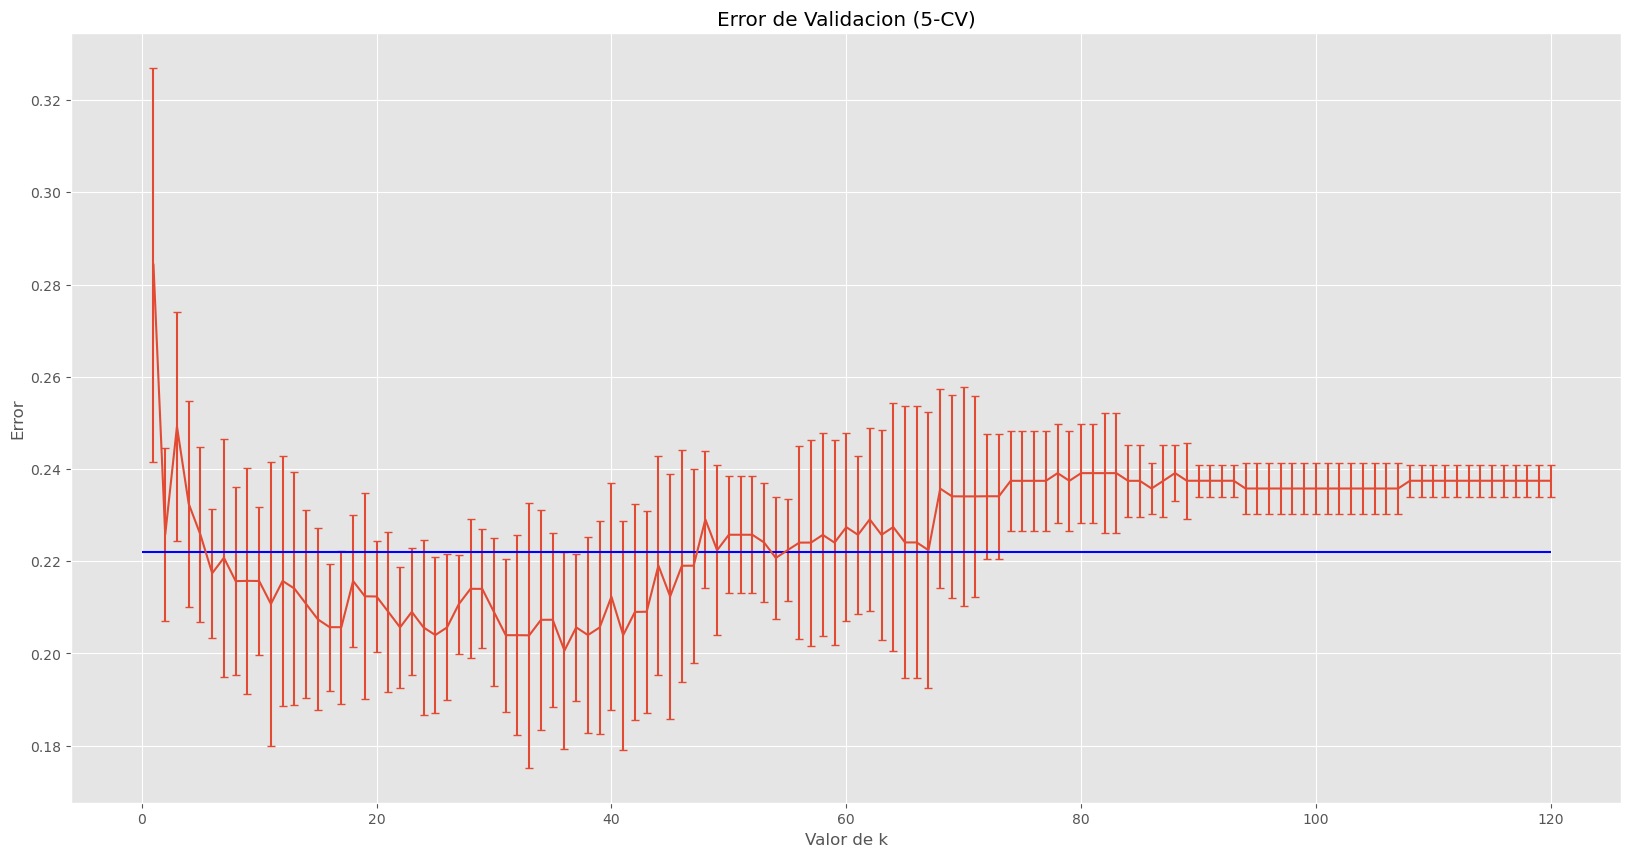

In [35]:

fig, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
ax.set_title("Error de Validacion (5-CV)")

ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
subset = cv_results_uniform[cv_results_uniform['param_n_neighbors'] <= 120]
ax.errorbar(subset['param_n_neighbors'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
ax.hlines(y=1-threshold, xmin=0, xmax=120, colors='blue')



El valor que escogeríamos por tanto sería:

Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica
del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test.**¿Cuál es el error de test para el valor del hiper-parámetro seleccionado por la validación cruzada?**

## Verificación de nuestros hiperparámetros

Esto no se haría **JAMÁS** en una situación real.
Pero como este es un ejemplo para aprender, vamos a ver cómo de lejos nos hemos quedado de los hiperparámetros "ideales".

Hacemos un Grid Search utilizando el conjunto de entrenamiento al completo (80% de los datos) y nuestro conjunto de validación va a ser el conjunto de test (20% de los datos).

In [36]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_scaled, dataset_test_X_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

k_neigh = KNeighborsClassifier()
modelCV_test = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV_test.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': range(1, 477)},
             return_train_score=True, scoring='accuracy')

In [37]:
test_results = pd.DataFrame(modelCV_test.cv_results_)
test_results.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,rank_test_score
0,1,0.700000,476
1,2,0.773333,60
2,3,0.766667,90
3,4,0.766667,90
4,5,0.793333,5
...,...,...,...
471,472,0.760000,110
472,473,0.760000,110
473,474,0.760000,110
474,475,0.760000,110


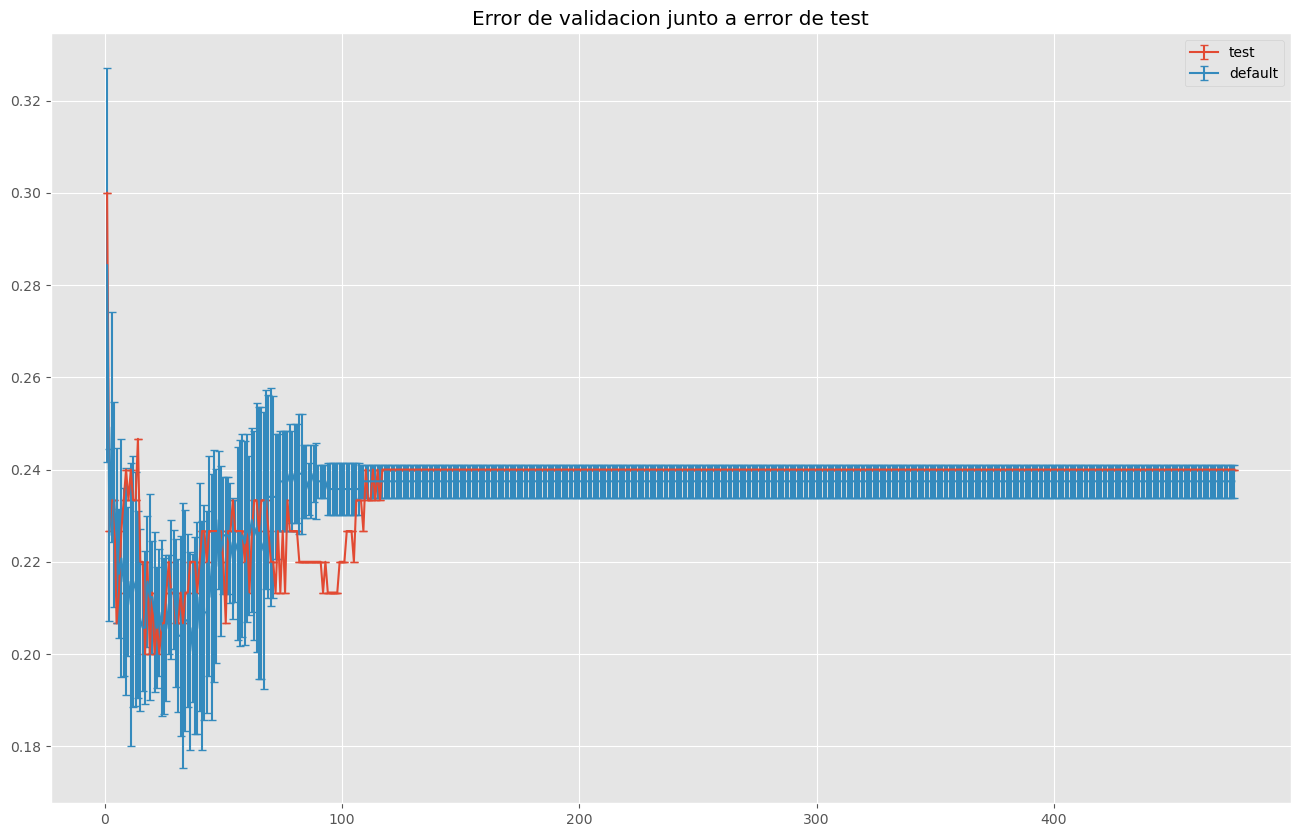

In [38]:
plt.figure(figsize=(16, 10))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion junto a error de test")
plt.errorbar(test_results['param_n_neighbors'],1 - test_results['mean_test_score'],
             test_results['std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error
plt.errorbar(cv_results_uniform['param_n_neighbors'],1 - cv_results_uniform['mean_test_score'],
             cv_results_uniform['std_test_score'], label='default', capsize=3) 
plt.legend(loc='upper right')
plt.show()

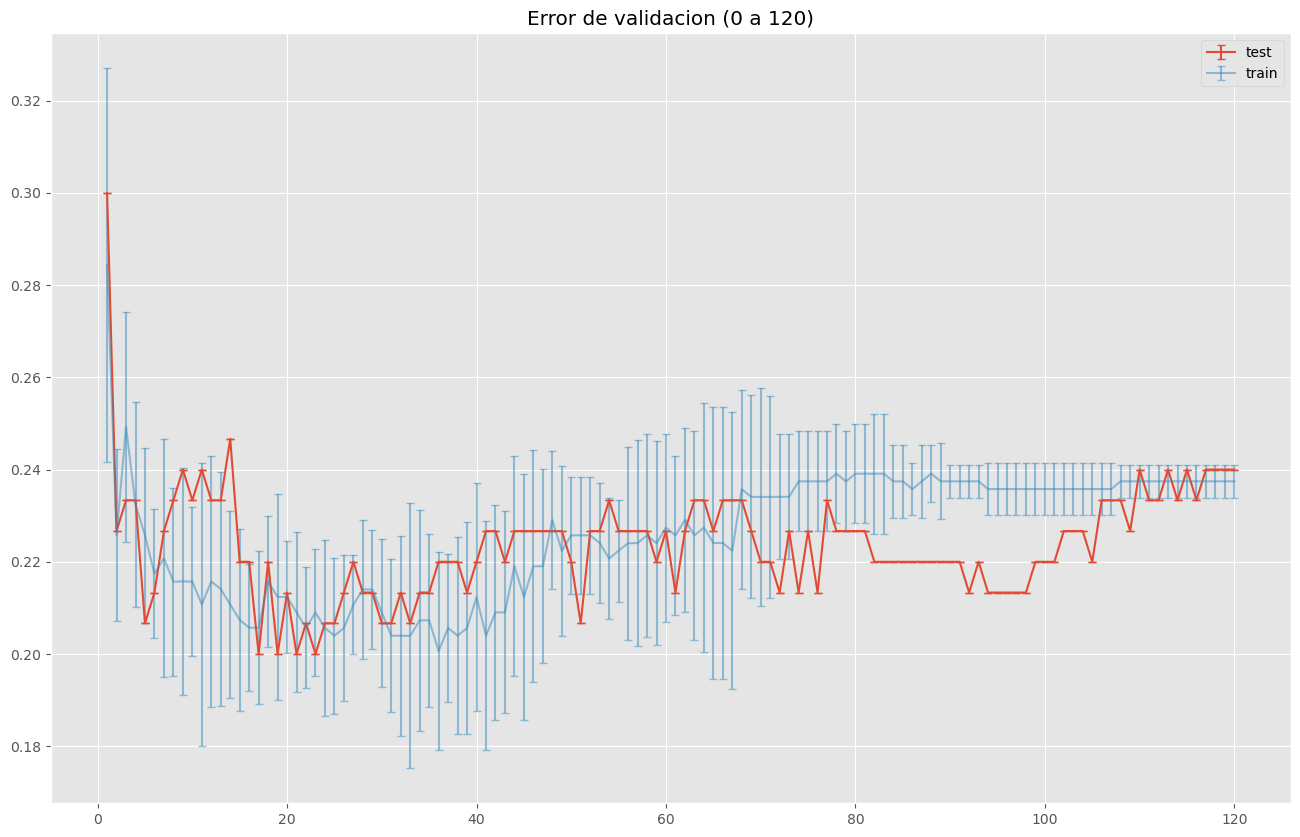

In [39]:
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_uniform[cv_results_uniform['param_n_neighbors'] <= 120]
subset_test= test_results[test_results['param_n_neighbors']<= 120]
plt.errorbar(subset_test['param_n_neighbors'],1 - subset_test['mean_test_score'],
             subset_test['std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(subset['param_n_neighbors'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='train', capsize=3,alpha=0.5)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [40]:
cv_results_best_test = test_results[test_results['rank_test_score'] == 1].sort_values(by='param_n_neighbors')
cv_results_best_test.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
16,17,0.8,0.0,1
18,19,0.8,0.0,1
20,21,0.8,0.0,1
22,23,0.8,0.0,1


In [41]:
test_results.loc[34, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

param_n_neighbors          35
mean_test_score      0.786667
rank_test_score            13
Name: 34, dtype: object

In [42]:
test_results.loc[21, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

param_n_neighbors          22
mean_test_score      0.793333
rank_test_score             5
Name: 21, dtype: object

In [43]:
test_results.loc[6, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

param_n_neighbors           7
mean_test_score      0.773333
rank_test_score            60
Name: 6, dtype: object

In [44]:
# Aplicar la regla de una desviación estándar
best_model = cv_results[cv_results['rank_test_score'] == 1].sort_values(by='param_n_neighbors').iloc[0]
mejor_score = best_model['mean_test_score']
mejor_std = best_model['std_test_score']


#cv_results_best_error_plus_std =  mejor_error -  mejor_std

cv_results_aux = cv_results[
     cv_results['mean_test_score']>= threshold
].sort_values(by='param_n_neighbors', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux = cv_results_aux.sort_values(by='param_n_neighbors')
cv_results_aux

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
5,6,0.782605,0.013973,38
6,7,0.779244,0.025804,43
7,8,0.784314,0.020409,33
8,9,0.784258,0.024577,37
9,10,0.784286,0.016105,35
10,11,0.789258,0.030783,25
11,12,0.784272,0.027148,36
12,13,0.785924,0.025314,32
13,14,0.789272,0.020307,24
14,15,0.792605,0.019735,17


In [45]:
test_results.loc[7:44, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,rank_test_score
7,8,0.766667,90
8,9,0.760000,110
9,10,0.766667,90
10,11,0.760000,110
11,12,0.766667,90
12,13,0.766667,90
13,14,0.753333,475
14,15,0.780000,32
15,16,0.780000,32
16,17,0.800000,1


Se observa que el 36 que era el supuesto mejor en trenamiento no dista mucho del score que saca el mejor en test por otro lado se observa que los mejores en test estan dentro de los modelos candidatos obtenidos por  la regla de una desviación estándar. por lo que podria decirse que entorno al 20-25 es donde se encuentra el minimo global

### Prueba a la hora de usar menos dimesiones

Como se comentó anterior mente  exitste una relación entre 'Frequency' y 'Monetary' por lo que se quiere observar si al reducir las dimensiones eliminando Frequency o Monetary hay mejoras, baja el rendimiento o se comporta de manera similar

In [46]:
dataset_train_X_reduce = dataset_train.loc[:,["Reciente","Frecuencia","Tiempo"]].astype(float)

dataset_test_X_reduce = dataset_test.loc[:, ["Reciente","Frecuencia","Tiempo"]].astype(float)


scaler = StandardScaler()

scaler.fit(dataset_train_X_reduce)

dataset_train_X_reduce_scaled = scaler.transform(dataset_train_X_reduce)
dataset_test_X_reduce_scaled = scaler.transform(dataset_test_X_reduce)

dataset_test_X_scaled

# ('Numero de muestras:', 598) auque pone este valor al usar  GridSearchCV me indica que son 477
print("Numero de muestras:", n_samples)

hyperparameters = {
    'n_neighbors': range(1, 477, 1),
    'n_jobs': [-1]  # Utilizar -1 para usar todos los procesadores disponibles y acelerar la búsqueda.
}
# hay
k_neigh = KNeighborsClassifier()
modelCV_reduce = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy', # parametro  top mejores en regresion mean scare error(skle pueda dar - std)
                       return_train_score=True)  # El warning es normal, pues el ejemplo es demasiado pequeño

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
modelCV_reduce.fit(dataset_train_X_scaled, dataset_train_Y)  # En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias

Numero de muestras: 598


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': range(1, 477)},
             return_train_score=True, scoring='accuracy')

In [47]:
cv_results_reduce = pd.DataFrame(modelCV_reduce.cv_results_)
cv_results.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
0,1,0.715700,0.042714,476
1,2,0.774216,0.018687,60
2,3,0.750784,0.024933,475
3,4,0.767535,0.022283,65
4,5,0.774258,0.018939,56
...,...,...,...,...
471,472,0.762549,0.003516,95
472,473,0.762549,0.003516,95
473,474,0.762549,0.003516,95
474,475,0.762549,0.003516,95


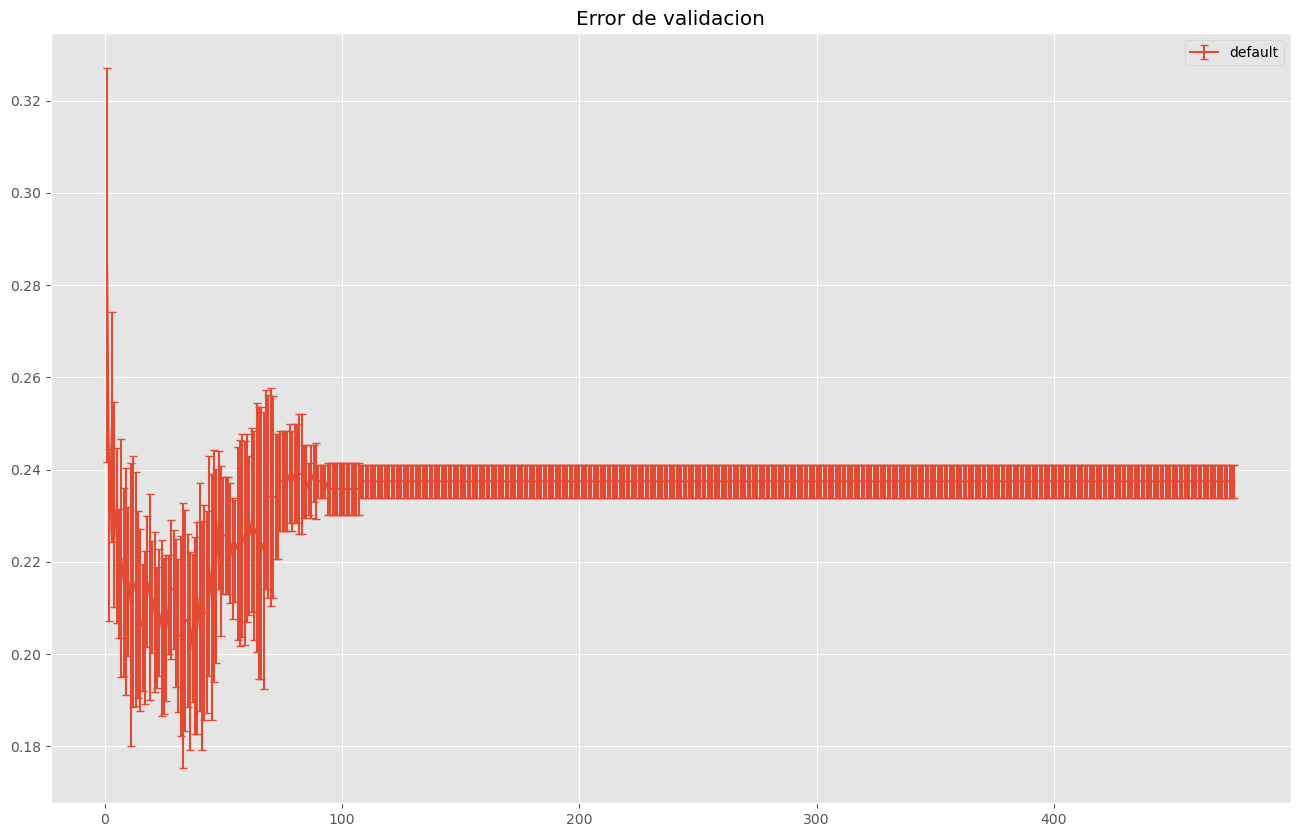

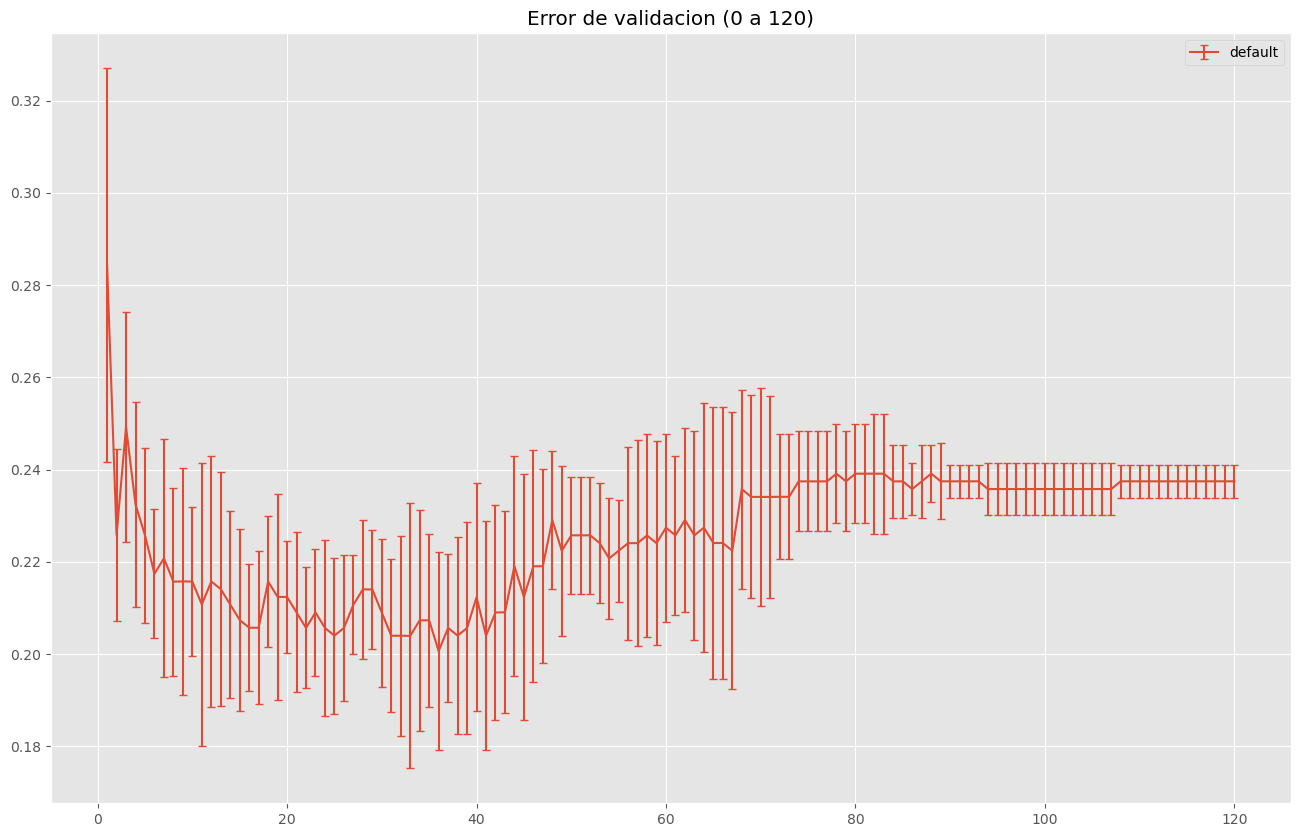

In [48]:
plt.figure(figsize=(16, 10))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion")
plt.errorbar(cv_results_reduce['param_n_neighbors'],1 - cv_results_reduce['mean_test_score'],
             cv_results_reduce['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_uniform[cv_results_reduce['param_n_neighbors'] <= 120]
plt.errorbar(subset['param_n_neighbors'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

**Nota** Como podemos observar tiene un comportamiento similar que usar la variable comprobemos el resto de pasos


In [49]:
cv_results_best = cv_results_reduce[cv_results_reduce['rank_test_score'] == 1].sort_values(by='param_n_neighbors')
cv_results_best.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
35,36,0.79937,0.021447,1


In [50]:
# Aplicar la regla de una desviación estándar
best_model = cv_results_reduce[cv_results_reduce['rank_test_score'] == 1].sort_values(by='param_n_neighbors').iloc[0]
mejor_score = best_model['mean_test_score']
mejor_std = best_model['std_test_score']


threshold =  mejor_score -  mejor_std

cv_results_aux = cv_results[
     cv_results['mean_test_score']>= threshold
].sort_values(by='param_n_neighbors', ascending=False)

cv_results_aux = cv_results_aux.loc[:, [
    'param_n_neighbors',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
    ]
]

cv_results_aux = cv_results_aux.sort_values(by='param_n_neighbors')
cv_results_aux

,param_n_neighbors,mean_test_score,std_test_score,rank_test_score
5,6,0.782605,0.013973,38
6,7,0.779244,0.025804,43
7,8,0.784314,0.020409,33
8,9,0.784258,0.024577,37
9,10,0.784286,0.016105,35
10,11,0.789258,0.030783,25
11,12,0.784272,0.027148,36
12,13,0.785924,0.025314,32
13,14,0.789272,0.020307,24
14,15,0.792605,0.019735,17


In [51]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y) + [0]*len(dataset_test_Y)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_reduce_scaled, dataset_test_X_reduce_scaled])
dataset_all_Y = pd.concat([dataset_train_Y, dataset_test_Y])

k_neigh = KNeighborsClassifier()
modelCV_test_reduce = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps,
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV_test_reduce.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsClassifier(),
             param_grid={'n_jobs': [-1], 'n_neighbors': range(1, 477)},
             return_train_score=True, scoring='accuracy')

In [52]:
test_results_reduce = pd.DataFrame(modelCV_test_reduce.cv_results_)
#test_results.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'rank_test_score']]

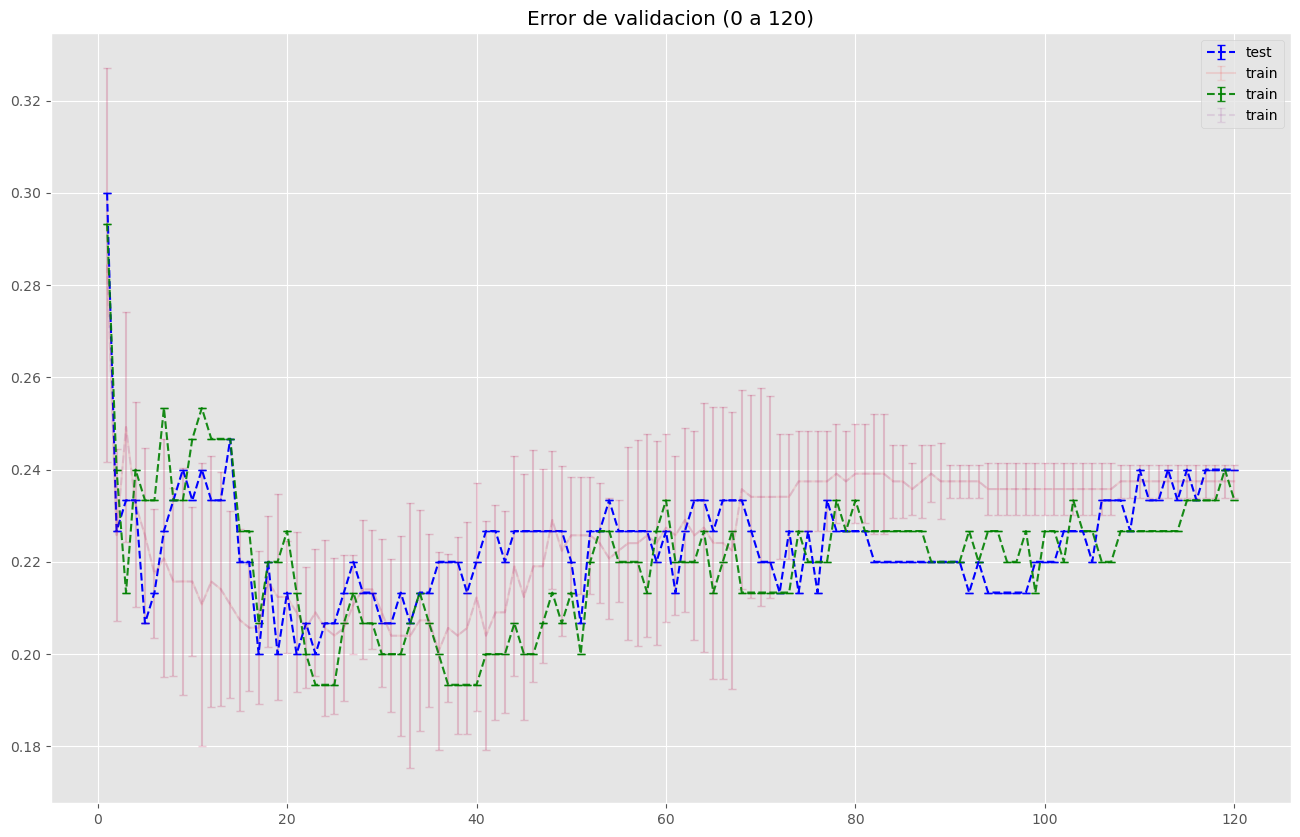

In [53]:
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")

subset_reduce = cv_results_reduce[test_results_reduce['param_n_neighbors'] <= 120]

subset_test_reduce= test_results_reduce[test_results['param_n_neighbors']<= 120]

subset = cv_results[cv_results['param_n_neighbors'] <= 120]

subset_test= test_results[test_results['param_n_neighbors']<= 120]

plt.errorbar(subset_test['param_n_neighbors'],1 - subset_test['mean_test_score'],
             subset_test['std_test_score'], label='test', capsize=3,  color='blue',linestyle='--')  # 1 - [] para imprimir el error

plt.errorbar(subset['param_n_neighbors'],1 - subset['mean_test_score'],
             subset['std_test_score'], label='train', capsize=3,alpha=0.1, color='red', )  # 1 - [] para imprimir el error

plt.errorbar(subset_test_reduce['param_n_neighbors'],1 - subset_test_reduce['mean_test_score'],
             subset_test_reduce['std_test_score'], label='train', capsize=3,alpha=0.9,  color='green', linestyle='--')  # 1 - [] para imprimir el error

plt.errorbar(subset_reduce['param_n_neighbors'],1 - subset_reduce['mean_test_score'],
             subset_reduce['std_test_score'], label='train', capsize=3,alpha=0.1, color='purple',linestyle='--')  # 1 - [] para imprimir el error

plt.legend(loc='upper right')
plt.show()

### Ejercio 3.

Repite el ejercicio 2 pero para el problema de regresión [Energy Efficiency](https://archive.ics.uci.edu/dataset/242/energy+efficiency) con la variable de salida
cooling load. Al ser un problema de regresión deberás utilizar KNeighborsRegressor, y como medida
de error de entrenamiento y test el MSE.

Nota. Al ser un problema de regresión, para estimar tanto el error de entrenamiento como el de
test (MSE) es necesario desestandarizar los errores calculados. Para desestandarizar el campo
`mean_test_score`, únicamente será necesario multiplicar cada valor por la varianza (cuadrado de la
desviación estándar) de las observaciones de Y del conjunto de entrenamiento. No se debe restar la
media, ya que los campos `splitX_test_score` se calculan como la diferencia entre el valor de
groundtruth y la predicción para cada dato de test, por lo que todas las operaciones de adición o
substracción ya se han tenido en cuenta. De forma similar, para desestandarizar el campo
`std_test_score`, únicamente será necesario multiplicar cada valor por la varianza de las
observaciones de Y del conjunto de entrenamiento.



In [54]:
!pwd

/home/alourido/Desktop/Master_de_big_data_USC/Statistical_learning/practices/4_seleccion_de_modelos_y_KNN


In [55]:
DATASET_ENERGY='./data/energy+efficiency/ENB2012_data.xlsx'
# Leer el archivo de datos y obtener la primera fila como nombres de columnas
data = pd.read_excel(DATASET_ENERGY)
NAME_ENERGY = data.columns.tolist()
#print(NAME_ENERGY)
#NAME_ENERGY=["Reciente","Frecuencia","Cantidad_Sangre","Tiempo","Donacion_marzo"]
if os.path.exists(DATASET_ENERGY):
    dataset_energy = pd.read_excel(DATASET_ENERGY, 
                          header=None,
                          skiprows=1,
                          names = NAME_ENERGY)
else:
    dataset_energy = d.DataFrame(np.array(
    [[0, 3, 2, 1], 
    [3, 0, 3, 0], 
    [0, 3, -1, 0], 
    [3, 0, 0, 1], 
    [1, 2, 1, 1], 
    [2, 1, 0, 0]]), columns=['X1', 'X2', 'X3', 'Y'])
dataset_energy

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [56]:
print(dataset_energy.dtypes)


X1    float64
X2    float64
X3    float64
X4    float64
X5    float64
X6      int64
X7    float64
X8      int64
Y1    float64
Y2    float64
dtype: object


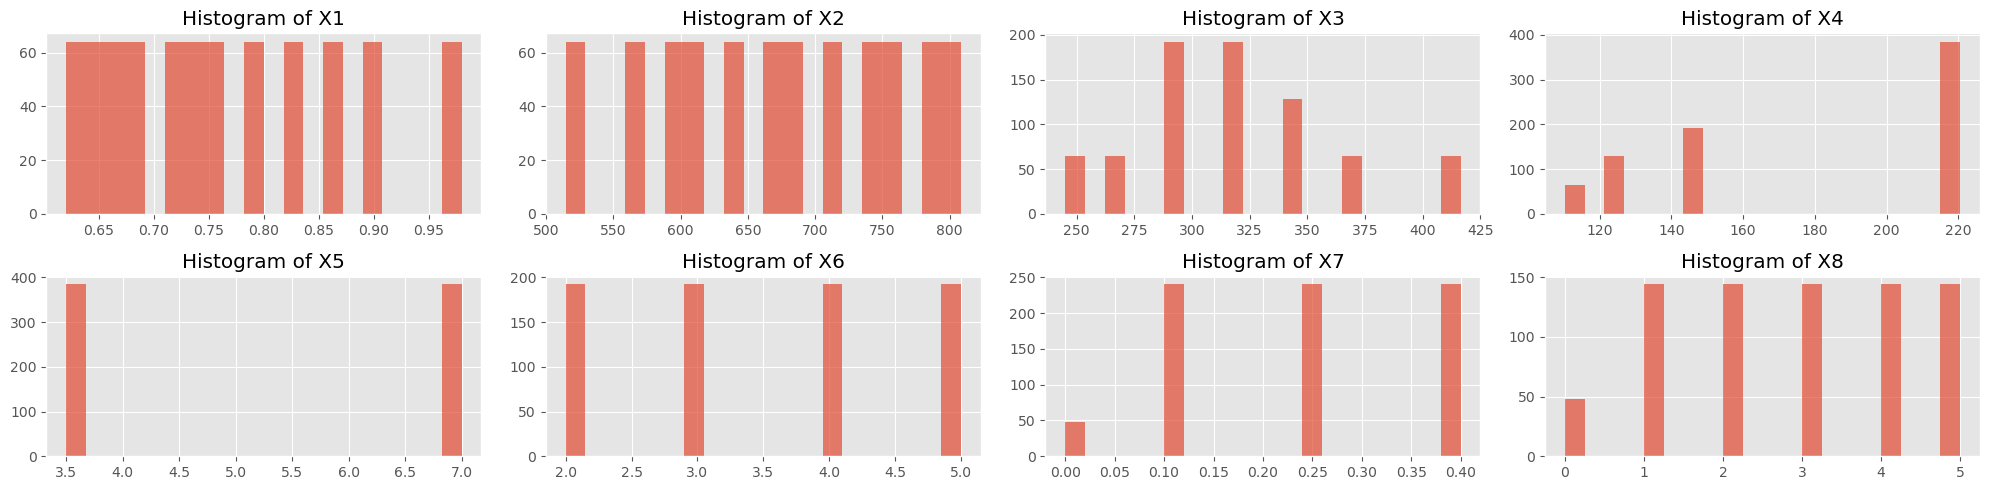

In [57]:
# Excluir la columna de la etiqueta
columns = dataset_energy.columns[:-2]

# Crear una cuadrícula de subtramas 2x4 para histogramas y gráficos de dispersión
fig, axs = plt.subplots(2, 4, figsize=(20, 5))

# Visualizar histogramas para todas las columnas
for i, column in enumerate(columns):
    row = i // 4  # Determinar la fila de la subtrama
    col = i % 4   # Determinar la columna de la subtrama
    axs[row, col].hist(dataset_energy[column], bins=20, alpha=0.7)
    axs[row, col].set_title("Histogram of {}".format(column))
# Ajustar el diseño
plt.tight_layout()
plt.show()

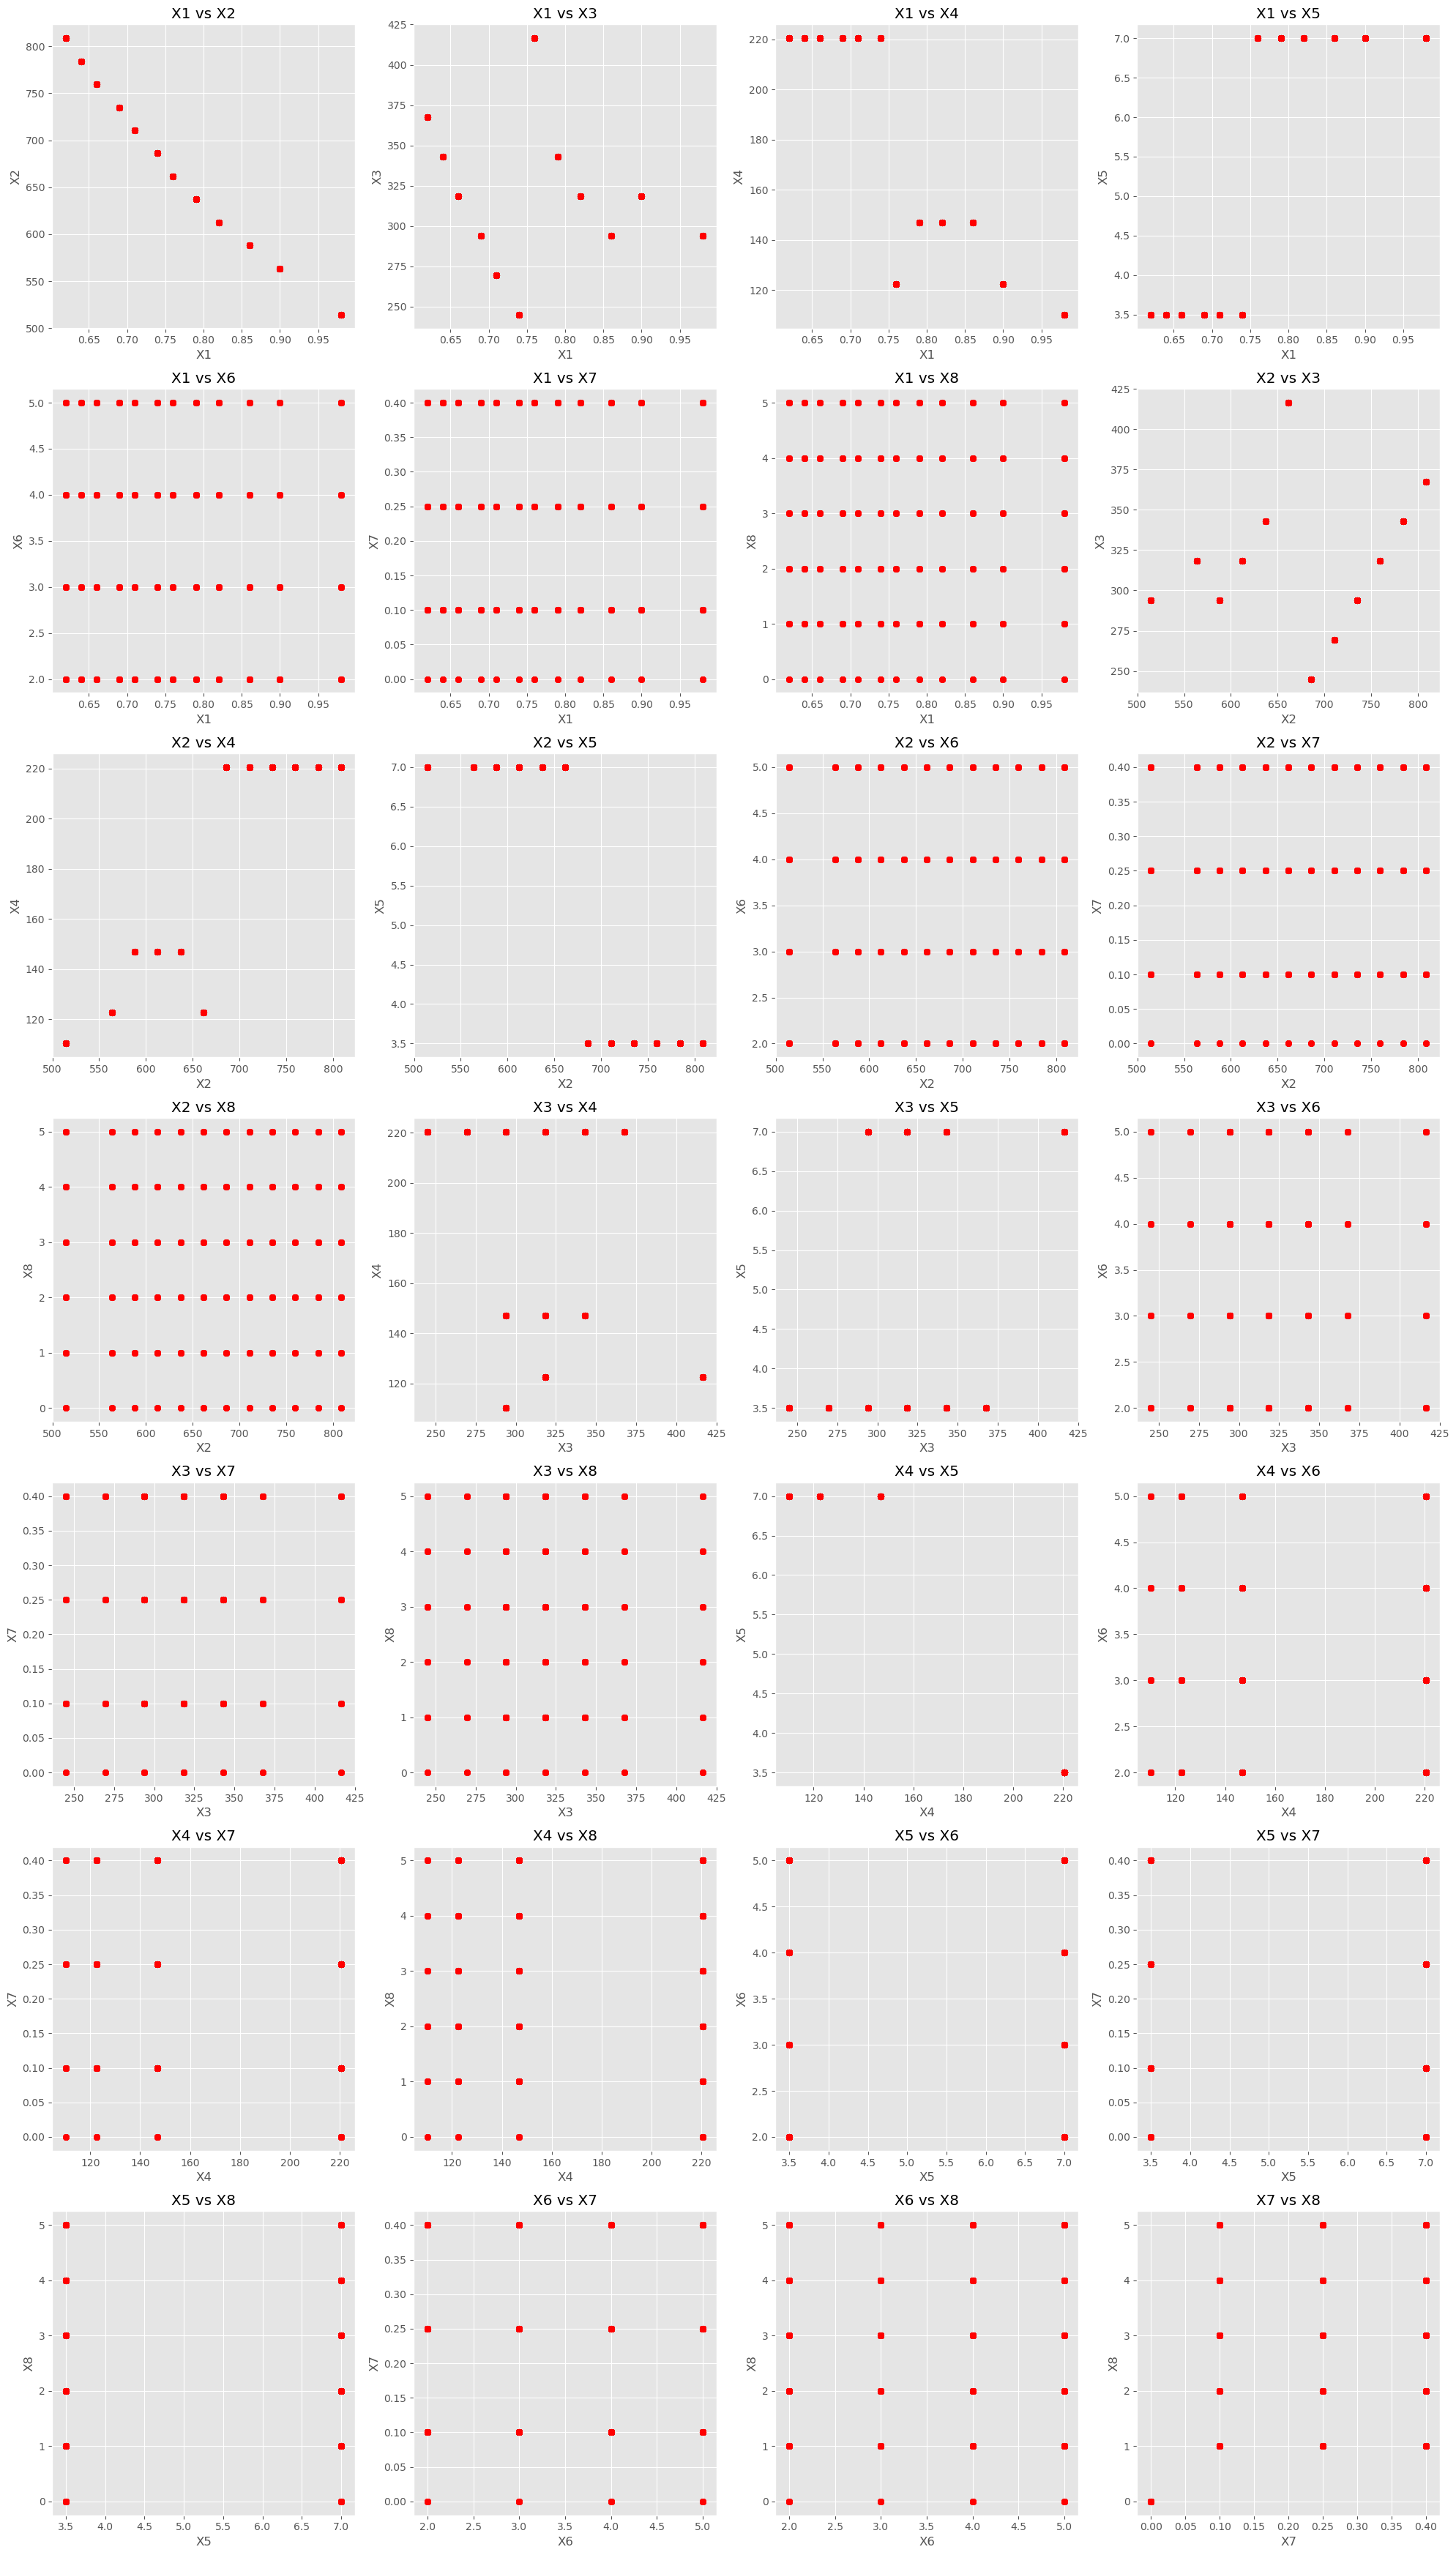

In [58]:
# Crear todas las combinaciones posibles de pares de variables
combinations = list(itertools.combinations(columns, 2))

num_cols=4
# Calcular el número de filas necesario para acomodar todas las combinaciones
num_combinations = len(combinations)
num_rows = num_combinations // num_cols + (num_combinations % num_cols > 0)

# Crear una cuadrícula de subtramas con un número suficiente de filas para todas las combinaciones
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))  # Ajustar el tamaño de figura según sea necesario

# Visualizar gráficos de dispersión para todas las combinaciones
for j, (var1, var2) in enumerate(combinations):
    row = j // num_cols
    col = j % num_cols
    axs[row, col].scatter(dataset_energy[var1], 
                          dataset_energy[var2], 
                          c='red')
    axs[row, col].set_title("{} vs {}".format(var1, var2))
    axs[row, col].set_xlabel(var1)
    axs[row, col].set_ylabel(var2)

# Ajustar el diseño para que no haya superposición
plt.tight_layout()

# Mostrar la figura
plt.show()

Se puede observar una cierta relación inversamente proporcional entre X1 Y X2  para otras variables no se opserva relaciones entre ellas.


División de los datos en entrenamiento (80%) y test (20%):

In [59]:
dataset_train_energy, dataset_test_energy = train_test_split(dataset_energy,
                            test_size=0.2, random_state=SEED_VALUE,
                                    )
dataset_test_energy.loc[:,columns]

,X1,X2,X3,X4,X5,X6,X7,X8
285,0.62,808.5,367.5,220.5,3.5,3,0.10,5
101,0.90,563.5,318.5,122.5,7.0,3,0.10,2
581,0.90,563.5,318.5,122.5,7.0,3,0.40,2
352,0.79,637.0,343.0,147.0,7.0,2,0.25,2
726,0.90,563.5,318.5,122.5,7.0,4,0.40,5
...,...,...,...,...,...,...,...,...
563,0.69,735.0,294.0,220.5,3.5,5,0.40,1
318,0.71,710.5,269.5,220.5,3.5,4,0.25,1
154,0.86,588.0,294.0,147.0,7.0,4,0.10,3
684,0.82,612.5,318.5,147.0,7.0,2,0.40,4


In [60]:
imp = SimpleImputer(missing_values=np.nan, fill_value='mean')
imp = imp.fit(dataset_train_energy)  # La media la calculamos SÓLO a partir del conjunto de train

# Los valores van a ser los mismos que antes, pues no tenemos datos faltantes
dataset_train_prep_energy = imp.transform(dataset_train_energy)
dataset_test_prep_energy = imp.transform(dataset_test_energy)

dataset_test_prep

array([[1.600e+01, 3.000e+00, 7.500e+02, 1.900e+01, 0.000e+00],
       [2.300e+01, 6.000e+00, 1.500e+03, 4.500e+01, 0.000e+00],
       [1.100e+01, 1.000e+00, 2.500e+02, 1.100e+01, 0.000e+00],
       [2.100e+01, 1.000e+00, 2.500e+02, 2.100e+01, 1.000e+00],
       [1.400e+01, 2.000e+00, 5.000e+02, 1.400e+01, 0.000e+00],
       [2.100e+01, 3.000e+00, 7.500e+02, 4.000e+01, 0.000e+00],
       [2.300e+01, 1.000e+00, 2.500e+02, 2.300e+01, 0.000e+00],
       [4.000e+00, 6.000e+00, 1.500e+03, 3.500e+01, 1.000e+00],
       [2.000e+00, 2.000e+00, 5.000e+02, 4.000e+00, 1.000e+00],
       [9.000e+00, 2.000e+00, 5.000e+02, 1.100e+01, 0.000e+00],
       [4.000e+00, 8.000e+00, 2.000e+03, 2.100e+01, 0.000e+00],
       [1.400e+01, 2.000e+00, 5.000e+02, 1.400e+01, 1.000e+00],
       [9.000e+00, 9.000e+00, 2.250e+03, 1.600e+01, 0.000e+00],
       [4.000e+00, 7.000e+00, 1.750e+03, 3.200e+01, 1.000e+00],
       [4.000e+00, 9.000e+00, 2.250e+03, 2.600e+01, 1.000e+00],
       [1.100e+01, 4.000e+00, 1.000e+03,

In [61]:
dataset_train_energy = pd.DataFrame(dataset_train_prep_energy,
                             columns=dataset_train_energy.columns,
                             index=dataset_train_energy.index)
dataset_test_energy = pd.DataFrame(dataset_test_prep_energy,
                            columns=dataset_test_energy.columns,
                            index=dataset_test_energy.index)

dataset_test_energy.loc[:,columns]

,X1,X2,X3,X4,X5,X6,X7,X8
285,0.62,808.5,367.5,220.5,3.5,3.0,0.10,5.0
101,0.90,563.5,318.5,122.5,7.0,3.0,0.10,2.0
581,0.90,563.5,318.5,122.5,7.0,3.0,0.40,2.0
352,0.79,637.0,343.0,147.0,7.0,2.0,0.25,2.0
726,0.90,563.5,318.5,122.5,7.0,4.0,0.40,5.0
...,...,...,...,...,...,...,...,...
563,0.69,735.0,294.0,220.5,3.5,5.0,0.40,1.0
318,0.71,710.5,269.5,220.5,3.5,4.0,0.25,1.0
154,0.86,588.0,294.0,147.0,7.0,4.0,0.10,3.0
684,0.82,612.5,318.5,147.0,7.0,2.0,0.40,4.0


**Estandarización de los datos**

Esto hay que hacerlo **ANTES** de dividir en conjuntos de entrenamiento y test. Además, como es un problema de **regresion**, estandarizaremos la variable dependientetambien .


In [62]:

scaler = StandardScaler()

scaler.fit(dataset_train_energy)

dataset_train_scaled_energy = scaler.transform(dataset_train_energy)

dataset_test_scaled_energy = scaler.transform(dataset_test_energy)

dataset_test_scaled_energy

array([[-1.33525558,  1.52364121,  1.12278518, ...,  1.40105783,
        -0.92406173, -1.09538181],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.54374136,
         0.75599529,  0.54110007],
       [ 1.28346607, -1.23517832,  0.00816901, ..., -0.54374136,
         1.43932427,  1.17051617],
       ...,
       [ 0.90936298, -0.95929637, -0.54913907, ...,  0.10452504,
         0.47929169,  0.16662393],
       [ 0.53525988, -0.68341441,  0.00816901, ...,  0.75279143,
         0.6816126 ,  0.40992763],
       [ 0.25468256, -0.40753246,  0.56547709, ...,  0.10452504,
         1.9857891 ,  1.47094335]])

In [63]:

print("mean [X1, X2, X3, X4, X5, X6, X7, X8, Y]: {}".format(scaler.mean_))
print("std [X1, X2, X3, X4, X5, X6, X7, X8, Y]: {}".format(scaler.scale_))


mean [X1, X2, X3, X4, X5, X6, X7, X8, Y]: [7.62768730e-01 6.73191368e+02 3.18140879e+02 1.77525244e+02
 5.19869707e+00 3.47394137e+00 2.31921824e-01 2.83876221e+00
 2.20573062e+01 2.43248697e+01]
std [X1, X2, X3, X4, X5, X6, X7, X8, Y]: [ 0.1069224  88.80609907 43.96132191 45.46444155  1.74924784  1.11918644
  0.13240652  1.54257571 10.08299108  9.45320583]


In [64]:
dataset_train_scaled_energy = pd.DataFrame(dataset_train_scaled_energy,
                             columns=dataset_train_energy.columns,
                             index=dataset_train_energy.index)
dataset_test_scaled_energy = pd.DataFrame(dataset_test_scaled_energy,
                            columns=dataset_test_energy.columns,
                            index=dataset_test_energy.index)


dataset_test_scaled_energy.loc[:,columns]

,X1,X2,X3,X4,X5,X6,X7,X8
285,-1.335256,1.523641,1.122785,0.945239,-0.971101,-0.423470,-0.996339,1.401058
101,1.283466,-1.235178,0.008169,-1.210292,1.029759,-0.423470,-0.996339,-0.543741
581,1.283466,-1.235178,0.008169,-1.210292,1.029759,-0.423470,1.269410,-0.543741
352,0.254683,-0.407532,0.565477,-0.671409,1.029759,-1.316976,0.136535,-0.543741
726,1.283466,-1.235178,0.008169,-1.210292,1.029759,0.470037,1.269410,1.401058
...,...,...,...,...,...,...,...,...
563,-0.680575,0.695995,-0.549139,0.945239,-0.971101,1.363543,1.269410,-1.192008
318,-0.493524,0.420113,-1.106447,0.945239,-0.971101,0.470037,0.136535,-1.192008
154,0.909363,-0.959296,-0.549139,-0.671409,1.029759,0.470037,-0.996339,0.104525
684,0.535260,-0.683414,0.008169,-0.671409,1.029759,-1.316976,1.269410,0.752791


**SEPARAMOS LAS VARIABLES**

In [65]:
dataset_train_X_energy = dataset_train_scaled_energy.loc[:, NAME_ENERGY[:-2]].astype(float)
dataset_train_Y_energy = dataset_train_scaled_energy.loc[:, NAME_ENERGY[-2:]]
dataset_train_X_energy

,X1,X2,X3,X4,X5,X6,X7,X8
663,-0.961152,0.971877,0.008169,0.945239,-0.971101,1.363543,1.269410,0.104525
712,-1.148204,1.247759,0.565477,0.945239,-0.971101,-1.316976,1.269410,0.752791
161,0.254683,-0.407532,0.565477,-0.671409,1.029759,-0.423470,-0.996339,0.104525
509,-0.493524,0.420113,-1.106447,0.945239,-0.971101,-0.423470,0.136535,1.401058
305,0.254683,-0.407532,0.565477,-0.671409,1.029759,-0.423470,0.136535,-1.192008
...,...,...,...,...,...,...,...,...
645,-0.025895,-0.131651,2.237401,-1.210292,1.029759,-0.423470,1.269410,0.104525
715,-1.148204,1.247759,0.565477,0.945239,-0.971101,1.363543,1.269410,0.752791
72,-0.212946,0.144231,-1.663755,0.945239,-0.971101,-1.316976,-0.996339,-1.192008
235,-1.148204,1.247759,0.565477,0.945239,-0.971101,1.363543,-0.996339,0.752791


In [66]:
dataset_test_X_energy = dataset_test_scaled_energy.loc[:, NAME_ENERGY[:-2]].astype(float)
dataset_test_Y_energy = dataset_test_scaled_energy.loc[:, NAME_ENERGY[-2:]]

dataset_test_Y_energy

,Y1,Y2
285,-0.924062,-1.095382
101,0.755995,0.541100
581,1.439324,1.170516
352,1.637678,2.066509
726,1.255847,1.530183
...,...,...
563,-0.757445,-0.753699
318,-0.940922,-0.939879
154,0.479292,0.166624
684,0.681613,0.409928


In [67]:
#Expected n_neighbors <= n_samples,  but n_samples = 491, n_neighbors = 492
# Expected n_neighbors <= n_samples,  n_samples = 477
# Si solo necesitas el número de muestras
n_samples = dataset_train_X_energy.shape[0]

# ('Numero de muestras:', 614) auque pone este valor al usar  GridSearchCV me indica que son 491
print("Numero de muestras:", n_samples)

hyperparameters = {
    'n_neighbors': range(1, 491, 1),
    'n_jobs': [-1]  # Utilizar -1 para usar todos los procesadores disponibles y acelerar la búsqueda.
}
# hay


Numero de muestras: 614


In [68]:
dataset_train_X_energy.index.equals(dataset_train_Y_energy.index)

True

In [69]:
from sklearn.neighbors import KNeighborsRegressor

In [70]:
k_neigh = KNeighborsRegressor()
modelCV_energy = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=5,
                       scoring="neg_mean_squared_error",
                       return_train_score=True)

# Por como funciona KNN, no haría falta establecer una semilla. Pero lo ponemos igualmente
np.random.seed(SEED_VALUE)

# En KNN no hay aprendizaje en sí, pero hay que ejecutar este comando para poder hacer inferencias
modelCV_energy.fit(dataset_train_X_energy, dataset_train_Y_energy)


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_jobs': [-1], 'n_neighbors': range(1, 491)},
             return_train_score=True, scoring='neg_mean_squared_error')

In [71]:
cv_results_energy = pd.DataFrame(modelCV_energy.cv_results_)
cv_results_energy.loc[:, [ 'param_n_neighbors', 'mean_test_score', 'std_test_score', 'rank_test_score']]
cv_results_energy['destandardized_mean_test_score'] = (-1) * cv_results_energy['mean_test_score'] * (scaler.scale_[8]**2)
cv_results_energy['destandardized_std_test_score'] = cv_results_energy['std_test_score'] * (scaler.scale_[8]**2)

In [72]:
cv_results_best = cv_results_energy[cv_results_energy['rank_test_score'] == 1]
colums_selected= [ 'param_n_neighbors', 'mean_test_score', 'std_test_score'
                        ,'destandardized_mean_test_score','destandardized_std_test_score','rank_test_score']
cv_results_best.loc[:, colums_selected]

,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.059569,0.005219,6.056209,0.530599,1


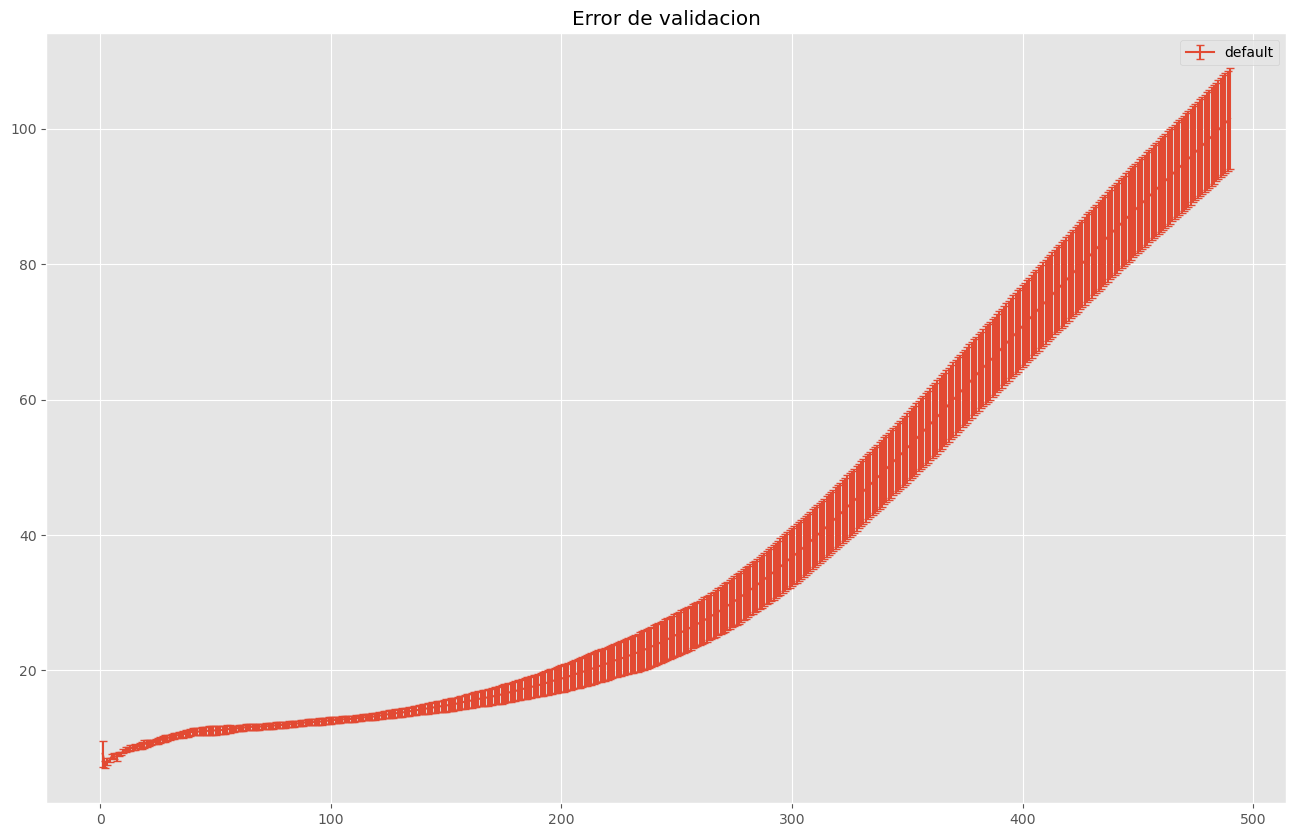

In [73]:
# separamos los pesos basados en cada 
cv_results_uniform = cv_results

plt.figure(figsize=(16, 10))  # Puedes cambiar estos valores según tus necesidades
# eje x xantidad de vecinos y en el y cuanto es el errror
plt.title("Error de validacion")
plt.errorbar(cv_results_energy['param_n_neighbors'],cv_results_energy['destandardized_mean_test_score'],
             cv_results_energy['destandardized_std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [74]:
cv_results_best = cv_results_energy[cv_results_energy['rank_test_score'] == 1]
cv_results_best.loc[:, colums_selected]

,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.059569,0.005219,6.056209,0.530599,1


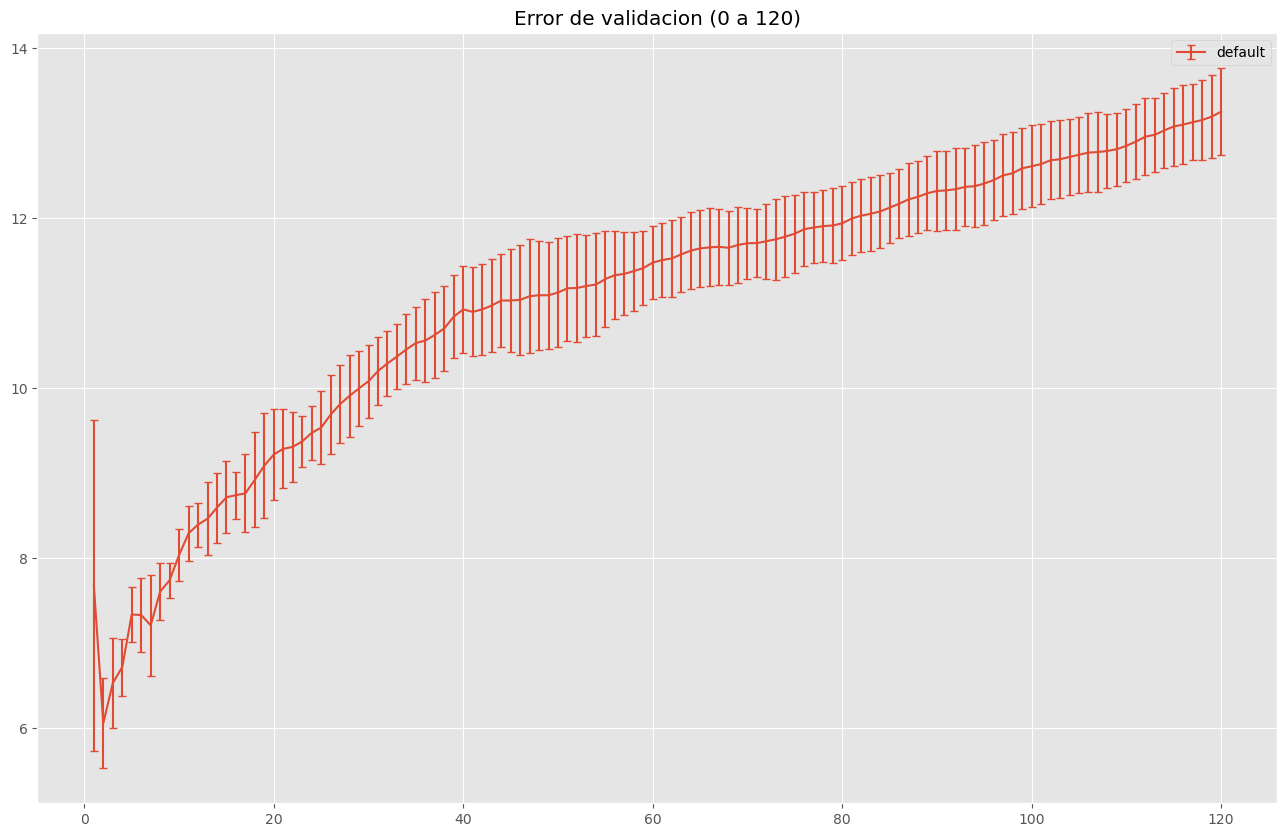

In [75]:
# Primera gráfica: De 0 a 110
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_energy[cv_results_energy['param_n_neighbors'] <= 120]
plt.errorbar(subset['param_n_neighbors'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [76]:
cv_results_best = cv_results_energy
cv_results_best.loc[:,colums_selected].sort_values(by='rank_test_score')

,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.059569,0.005219,6.056209,0.530599,1
2,3,-0.064201,0.005242,6.527127,0.532983,2
3,4,-0.066067,0.003301,6.716788,0.335650,3
6,7,-0.070899,0.005822,7.208107,0.591924,4
5,6,-0.072090,0.004303,7.329179,0.437508,5
...,...,...,...,...,...,...
485,486,-0.985692,0.072169,100.212021,7.337161,486
486,487,-0.988905,0.072346,100.538717,7.355173,487
487,488,-0.992137,0.072564,100.867295,7.377388,488
488,489,-0.995449,0.072770,101.204055,7.398286,489


In [77]:
# Aplicar la regla de una desviación estándar
best_model = cv_results_energy[cv_results_energy['rank_test_score'] == 1].sort_values(by='param_n_neighbors').iloc[0]
mejor_score = best_model['destandardized_mean_test_score']
mejor_std = best_model['destandardized_std_test_score']

threshold_energy=mejor_score+mejor_std
print(threshold_energy)
cv_results_aux = cv_results_energy[
     cv_results_energy['destandardized_mean_test_score']<=threshold_energy
].sort_values(by='param_n_neighbors', ascending=False)

cv_results_aux = cv_results_aux.loc[:, colums_selected]

cv_results_aux = cv_results_aux.sort_values(by='param_n_neighbors')
cv_results_aux


6.586807621372629


,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
1,2,-0.059569,0.005219,6.056209,0.530599,1
2,3,-0.064201,0.005242,6.527127,0.532983,2


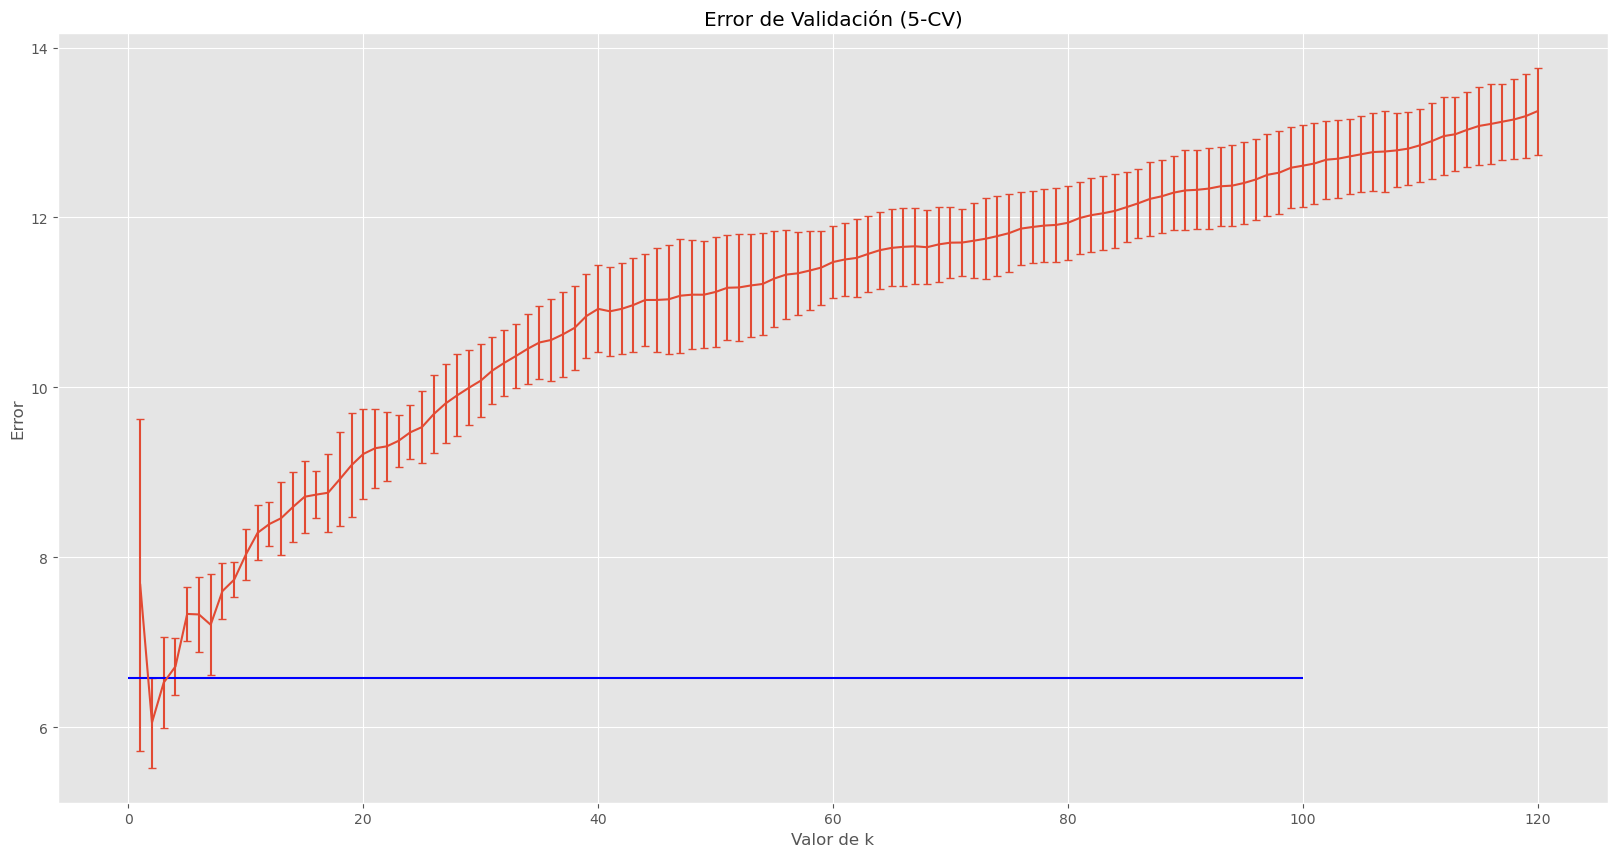

In [78]:


fig, ax = plt.subplots(figsize=(20, 10), ncols=1, nrows=1)
ax.set_title("Error de Validación (5-CV)")
ax.set_xlabel("Valor de k")
ax.set_ylabel("Error")
ubset = cv_results_energy[cv_results_energy['param_n_neighbors'] <= 120]
plt.errorbar(subset['param_n_neighbors'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='default', capsize=3)  # 1 - [] para imprimir el error
ax.hlines(y=threshold_energy, xmin=0, xmax=100, colors='blue')



En este caso se el valor que se obtiene como el mejor y el que da el la regla de una desviación estándar seria la misma cantidad de neighbors


In [79]:
# Hacemos un Grid Search sin Cross Validation, únicamente con entrenamieto y validación (PredefinedSplit)

# Creamos una lista con `-1` para los índices de entrenamiento y `0` para los índices de validación
split_test_fold = [-1]*len(dataset_train_Y_energy) + [0]*len(dataset_test_Y_energy)
ps = PredefinedSplit(test_fold=split_test_fold)

# Juntamos los conjuntos de entrenamiento y test, fingiendo que son un sólo conjunto de entrenamiento-validación
dataset_all_X_scaled = np.vstack([dataset_train_X_energy, dataset_test_X_energy])
dataset_all_Y = pd.concat([dataset_train_Y_energy, dataset_test_Y_energy])

k_neigh = KNeighborsRegressor()
modelCV_test_energy = GridSearchCV(k_neigh,
                       hyperparameters,
                       cv=ps,
                       scoring='neg_mean_squared_error',
                       return_train_score=True)

np.random.seed(SEED_VALUE)  # Por como funciona KNN, no haría falta establecer semilla. Pero lo ponemos igualmente
modelCV_test_energy.fit(dataset_all_X_scaled, dataset_all_Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=KNeighborsRegressor(),
             param_grid={'n_jobs': [-1], 'n_neighbors': range(1, 491)},
             return_train_score=True, scoring='neg_mean_squared_error')

In [80]:
test_results_energy = pd.DataFrame(modelCV_test_energy.cv_results_)
test_results_energy['destandardized_mean_test_score'] = (-1) * test_results_energy['mean_test_score'] * (scaler.scale_[8]**2)
test_results_energy['destandardized_std_test_score'] = test_results_energy['std_test_score'] * (scaler.scale_[8]**2)
test_results_energy.loc[:, colums_selected]

,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
0,1,-0.144213,0.0,14.661703,0.0,71
1,2,-0.111674,0.0,11.353576,0.0,18
2,3,-0.090530,0.0,9.203884,0.0,2
3,4,-0.100655,0.0,10.233243,0.0,13
4,5,-0.104139,0.0,10.587466,0.0,15
...,...,...,...,...,...,...
485,486,-0.690477,0.0,70.198550,0.0,486
486,487,-0.693560,0.0,70.511996,0.0,487
487,488,-0.696143,0.0,70.774615,0.0,488
488,489,-0.698666,0.0,71.031053,0.0,489


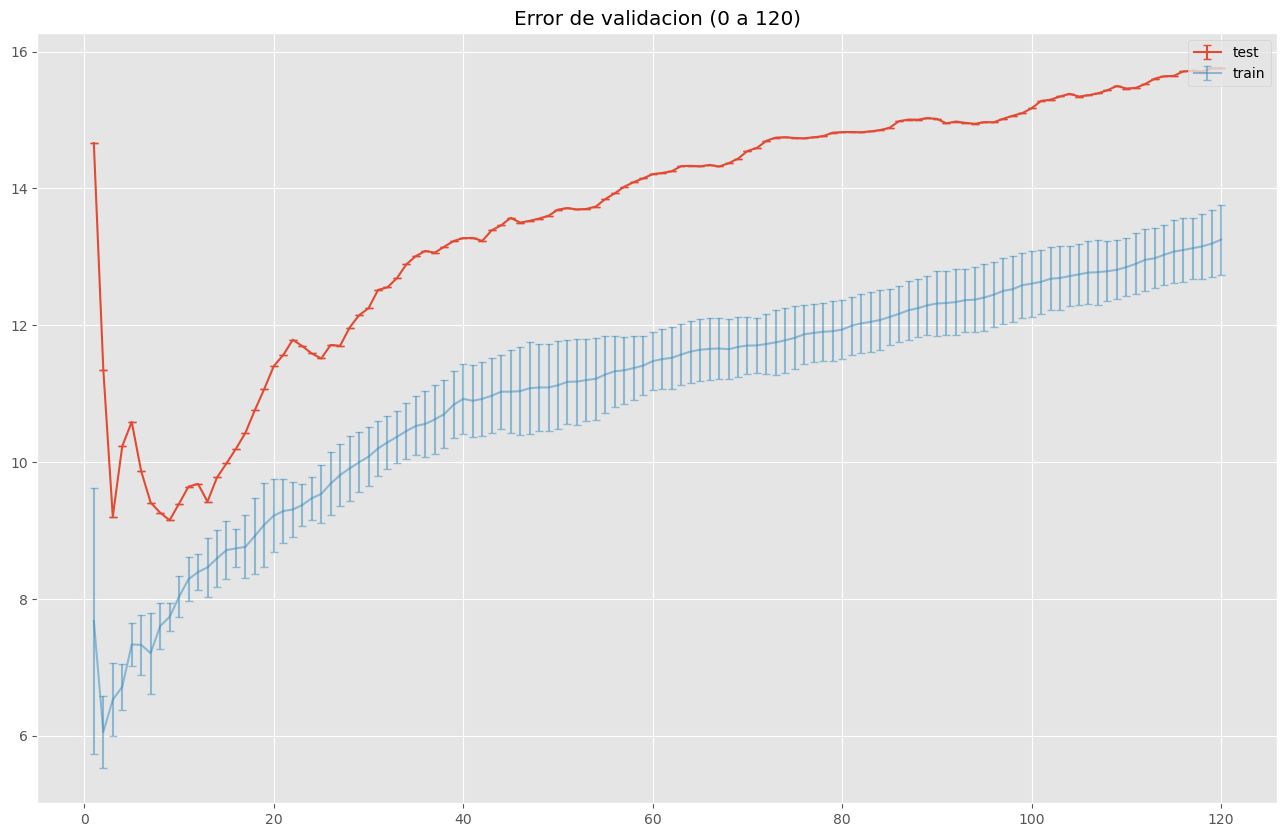

In [81]:
plt.figure(figsize=(16, 10))
plt.title("Error de validacion (0 a 120)")
subset = cv_results_energy[cv_results_energy['param_n_neighbors'] <= 120]
subset_test= test_results_energy[test_results_energy['param_n_neighbors']<= 120]
plt.errorbar(subset_test['param_n_neighbors'],subset_test['destandardized_mean_test_score'],
             subset_test['destandardized_std_test_score'], label='test', capsize=3)  # 1 - [] para imprimir el error

plt.errorbar(subset['param_n_neighbors'],subset['destandardized_mean_test_score'],
             subset['destandardized_std_test_score'], label='train', capsize=3,alpha=0.5)  # 1 - [] para imprimir el error
plt.legend(loc='upper right')
plt.show()

In [82]:
 
test_results_energy.loc[:, colums_selected].sort_values(by='destandardized_mean_test_score')

,param_n_neighbors,mean_test_score,std_test_score,destandardized_mean_test_score,destandardized_std_test_score,rank_test_score
8,9,-0.090006,0.0,9.150577,0.0,1
2,3,-0.090530,0.0,9.203884,0.0,2
7,8,-0.091098,0.0,9.261645,0.0,3
9,10,-0.092402,0.0,9.394190,0.0,4
6,7,-0.092539,0.0,9.408153,0.0,5
...,...,...,...,...,...,...
485,486,-0.690477,0.0,70.198550,0.0,486
486,487,-0.693560,0.0,70.511996,0.0,487
487,488,-0.696143,0.0,70.774615,0.0,488
488,489,-0.698666,0.0,71.031053,0.0,489
